In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import fits
from astropy.stats import mad_std, sigma_clip
from astropy.convolution import Gaussian1DKernel, convolve

import ccdproc
from ccdproc import ImageFileCollection, CCDData

import warnings
from astropy.utils.exceptions import AstropyWarning

WORKDIR = '20220916'
#WORKDIR = '../Downloads/20221008'
#WORKDIR = 'raw2'
PROCESSING = os.path.join(WORKDIR, 'processing')

try:
    os.mkdir(PROCESSING)
except OSError:
    pass

import emcee
from scipy.optimize import fmin, curve_fit
from scipy.interpolate import LSQUnivariateSpline, LSQBivariateSpline

CCDproc tutorial: https://mwcraig.github.io/ccd-as-book/00-00-Preface.html

INT IDS: https://www.ing.iac.es//astronomy/instruments/ids/ids_eev10.html

I created this notebook with the help of these other notebooks:
  * https://github.com/growth-astro/growth-school-2020/blob/master/spectroscopy/spectra_guide_solved.ipynb
  * https://github.com/aayush3009/INT-IDS-DataReduction/blob/master/INT%20IDS%20quick%20reduction%20BRIGHT.ipynb

In [ ]:
def plot_image(data):
    m, s = np.nanmean(data), np.nanstd(data)

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(data, interpolation='nearest',
               cmap='gray',
               vmin=m-s, vmax=m+s,
               origin='lower')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)    
    return ax

## Image correction

In [15]:
from functools import partial
from multiprocessing import Pool
from astropy.modeling import polynomial, fitting
from scipy.ndimage import binary_dilation


from scipy.signal import find_peaks

def fit_chebyshev(row, degree=7, grow=3):
    """
    Fit Chebyshev1D model to a CCD row, including masking of outlier pixels
    
    Params
    ------
    row : array,
        Input CCD row to fit polynomial to.
    degree : int,
        Chebyshev Polynomial Order
    grow : int,
        Number of iterations to dilate around masked pixels
    """

    fitter = fitting.LinearLSQFitter()
    input_mask = row.mask
    clipped = sigma_clip(row, sigma=15, stdfunc=mad_std)
    clipped_pixels = np.array(clipped.mask+row.mask).astype('float')
    clipped_pixels = binary_dilation(clipped_pixels, iterations=grow)

    row[clipped_pixels==1] = np.median(row)
    masked_row = np.ma.array(data=row, 
                             mask=(clipped_pixels == 1), 
                             fill_value=np.median(row))
    x = np.arange(len(row))
    model = polynomial.Chebyshev1D(degree=degree)
    fitted_model = fitter(model, x, row)
    
    return fitted_model(np.arange(len(row)))

def fit_background(data, degree=7, grow=3, verbose=True, njobs=12):
    """
    Parallelised background estimation for longslit CCD image
    
    Params
    ------
    data : array,
        Input CCD data for background estimation.
    degree : int,
        Chebyshev Polynomial Order
    grow : int,
        Number of iterations to dilate around masked pixels
    njobs : int
        Number of processes to initiate for fitting
    """
    kwargs={'degree': degree, 'grow': grow}    
    pool = Pool(processes=njobs)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        fitted_sky = pool.map(partial(fit_chebyshev, **kwargs), data)
    pool.close()
        
    return np.array(fitted_sky).astype('float')

BIASSEC: '[1:366,4105:4190]'

TRIMSEC: '[1:366,1:4099]'

In [16]:
def validate_method(method):
    """Checks the valid method for combining images.
    """
    valid_methods = ['median', 'average']
    assert method in valid_methods, f"the method used in not valid, choose from {valid_methods}"
    
    
def create_images_list(observations, obstype, subtract_overscan=False, trim_image=True, master_bias=None):
    """Creates a list of images.
    
    The images can be overscan subtracted, trimmed and bias subtracted.
    """
    images_list = []
    
    for filename in observations.files_filtered(include_path=True, obstype=obstype):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", AstropyWarning)
            ccd = CCDData.read(filename, hdu=1, unit=u.adu)
            
        ## Set up the reduction based on Gain and Readout.
        ccd = ccdproc.create_deviation(
            ccd, 
            gain = ccd.header['GAIN']*u.electron / u.adu,
            readnoise = ccd.header['READNOIS'] * u.electron
        )
        ## Actually correct for gain.
        ccd = ccdproc.gain_correct(ccd, ccd.header['GAIN'] * u.electron / u.adu)

        if subtract_overscan:
            #ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section=ccd.header['BIASSEC'])
            ccd = ccdproc.subtract_overscan(ccd, median = True, overscan_axis = 0, overscan=ccd[4110:4190, :])
        if trim_image:
            #ccd = ccdproc.trim_image(ccd, ccd.header['TRIMSEC'])
            ccd = ccdproc.trim_image(ccd[:4096, :])
        if master_bias is not None:
            ccd = ccdproc.subtract_bias(ccd, master_bias) 
        images_list.append(ccd)
        
    return images_list


def inv_median(array):
    """Inverse median function.
    """
    return 1 / np.nanmedian(array)
    
    
def combine_images(images_list, method='average', scale=None, flat=False):
    """Combines a list of images.
    """
    validate_method(method)
    if method=='median':
        master_image = ccdproc.combine(images_list, method=method, scale=scale)
    
    elif method=='average':
        master_image = ccdproc.combine(images_list, method=method, scale=scale,
                                       sigma_clip=True, sigma_clip_low_thresh=5, 
                                       sigma_clip_high_thresh=5, sigma_clip_func=np.ma.median, 
                                       signma_clip_dev_func=mad_std, mem_limit=350e6)   
        
    if flat:
        ## Now, must find the specific spectroscopic flat. This involves making a model of the lamp spectra, and 
        ## finding the variation throughout this.
        collapsed_spectra = np.sum(master_image, axis = 1)
        gauss = Gaussian1DKernel(stddev = 10)
        smooth_flat = convolve(collapsed_spectra, gauss)

        master_image.data = ((np.array(master_image).T / smooth_flat)).T
        master_image.data = master_image.data / np.mean(master_image.data)
        
    return master_image
        

def create_master_bias(observations, subtract_overscan=False, trim_image=True, method='average'):
    """Creates a master BIAS.
    
    The BIAS images can be overscan subtracted and trimmed.
    """
    obstype = 'BIAS'
    bias_list = create_images_list(observations, obstype, subtract_overscan, trim_image)
    master_bias = combine_images(bias_list, method)
    print(f'{len(bias_list)} images combined for the master BIAS')
    
    return master_bias
    
    
def create_master_flat(observations, master_bias=None, subtract_overscan=False, trim_image=True, method='average', scale_flats=True): 
    """Creates a master FLAT.
    
    The FLAT images can be overscan subtracted, trimmed and bias subtracted.
    """
    obstype = 'FLAT'
    if scale_flats:
        scale = inv_median
    else:
        scale = None
        
    subtract_overscan = False
    flat_list = create_images_list(observations, obstype, subtract_overscan, trim_image, master_bias)
    master_flat = combine_images(flat_list, method, scale=scale)
    print(f'{len(flat_list)} images combined for the master FLAT')
    
    return master_flat
        
        
def reduce_images(observations, master_bias=None, master_flat=None, subtract_overscan=False, trim_image=True, method='median'):
    """Reduces science images.
    
    The images can be overscan subtracted, trimmed, bias subtracted and flat corrected.
    """
    obs_df = observations.summary.to_pandas()
    object_names = obs_df[obs_df.obstype=='TARGET'].object.unique()

    red_images = []
    for object_name in object_names:
        if 'focus' in object_name:
            continue  # skips this
        print("Reducing:", object_name)
        target_list = []
        
        for filename in observations.files_filtered(include_path=True, object=object_name):
            hdu = fits.open(filename)
            print(filename)
            header = hdu[0].header+hdu[1].header
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", AstropyWarning)
                ccd = CCDData(hdu[1].data, header=header, unit=u.adu)
                
            ccd = ccdproc.create_deviation(
                ccd,
                gain = ccd.header['GAIN'] * u.electron / u.adu,
                readnoise = ccd.header['READNOIS'] * u.electron
            )
            ccd = ccdproc.gain_correct(ccd, ccd.header['GAIN'] * u.electron / u.adu)

            try:
                ccd = ccdproc.cosmicray_lacosmic(ccd, niter=10)
                if subtract_overscan:
                    ccd = ccdproc.subtract_overscan(ccd, median=True, overscan_axis=0, overscan=ccd[4110:4190,:])
                if trim_image:
                    ccd = ccdproc.trim_image(ccd[:4096,:])
                if master_bias is not None:
                    ccd = ccdproc.subtract_bias(ccd, master_bias)
                if master_flat is not None:
                    ccd = ccdproc.flat_correct(ccd, master_flat, min_value = 0.1)
        
                # Rotate Frame
                ccd.data = ccd.data.T
                ccd.mask = ccd.mask.T
                #ccd.write('obj_'+filename, overwrite=True)
                target_list.append(ccd)
            except Exception as error:
                print(error)

        if len(target_list)>0:
            validate_method(method)
            combiner = ccdproc.Combiner(target_list)
            if method=='average':
                red_target = combiner.average_combine()
            elif method=='median':
                red_target = combiner.median_combine()
            red_images.append(red_target)
        
    return red_images


def obs_plots(observations, obstype):
    """Plots all images of a given 'obstype'.
    """    
    for filename in observations.files_filtered(include_path=True, obstype=obstype):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", AstropyWarning)
            ccd = CCDData.read(filename, hdu=1, unit=u.electron)
            plot_image(ccd.data.T)

## Preliminary Tests

### BIAS

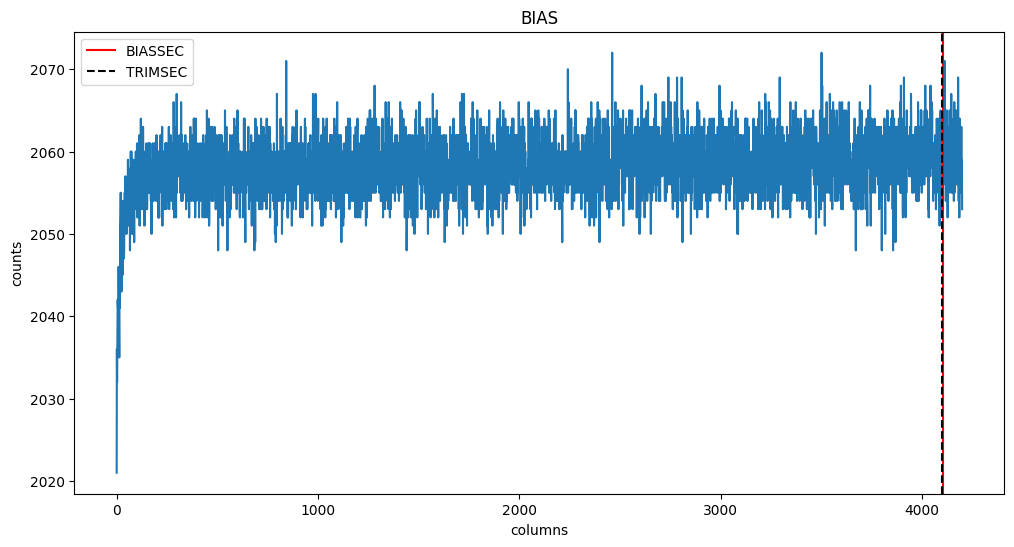

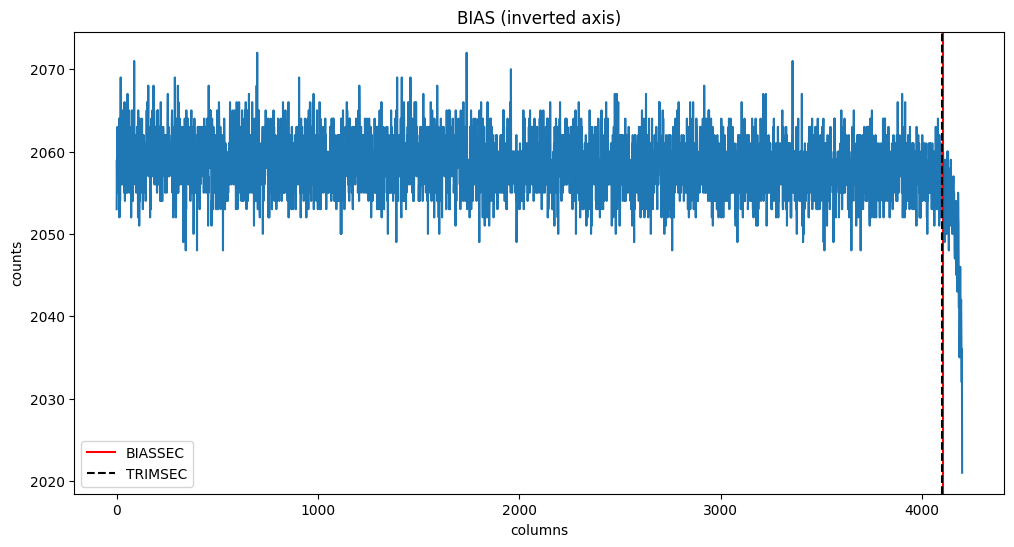

In [44]:
bias_file = '20220916/r1632287.fit'

ccd = CCDData.read(bias_file, hdu=1, unit=u.electron)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ccd.data[:, 150])

biassec = ccd.header['BIASSEC']
biassec_col = int(biassec.split(',')[-1][:4])
trimsec = ccd.header['TRIMSEC']
trimsec_col = int(trimsec.split(',')[-1][2:-1])
ax.axvline(biassec_col, c='r', label='BIASSEC')
ax.axvline(trimsec_col, c='k', ls='--', label='TRIMSEC')
ax.set_xlabel('columns')
ax.set_ylabel('counts')
ax.set_title('BIAS')
ax.legend()

plt.show()

# invert axis
ccd = CCDData.read(bias_file, hdu=1, unit=u.electron)
ccd = ccd[::-1]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ccd.data[:, 150])

biassec = ccd.header['BIASSEC']
biassec_col = int(biassec.split(',')[-1][:4])
trimsec = ccd.header['TRIMSEC']
trimsec_col = int(trimsec.split(',')[-1][2:-1])
ax.axvline(biassec_col, c='r', label='BIASSEC')
ax.axvline(trimsec_col, c='k', ls='--', label='TRIMSEC')
ax.set_xlabel('columns')
ax.set_ylabel('counts')
ax.set_title('BIAS (inverted axis)')
ax.legend()

plt.show()

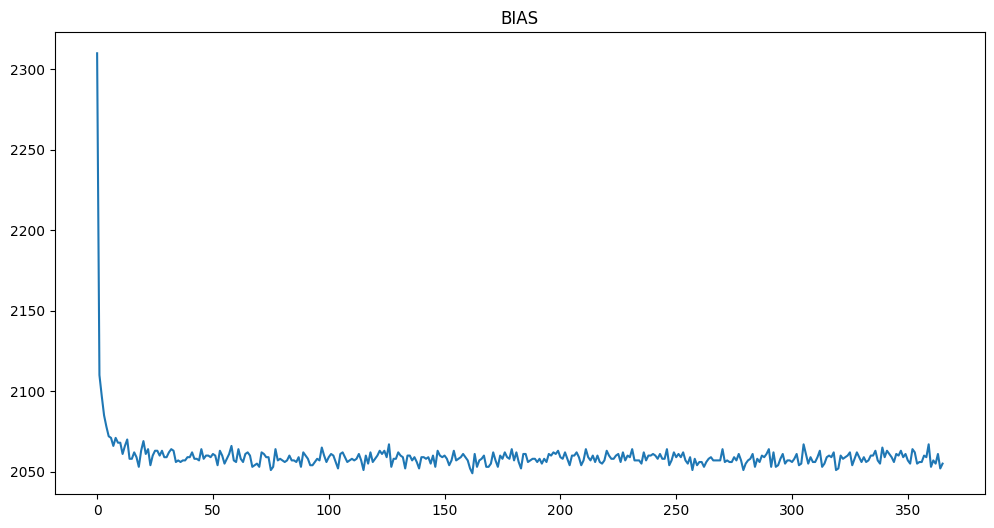

In [43]:
ccd = CCDData.read(bias_file, hdu=1, unit=u.electron)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ccd.data[2000,:])
ax.set_title('BIAS')

plt.show()

the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma.
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma.
Changed DATE-OBS from '2022-09-16        ' to '2022-09-16T00:00:00.0''. [astropy.wcs.wcs]
Changed DATE-OBS from '2022-09-16        ' to '2022-09-16T00:00:00.0''.


<AxesSubplot: >

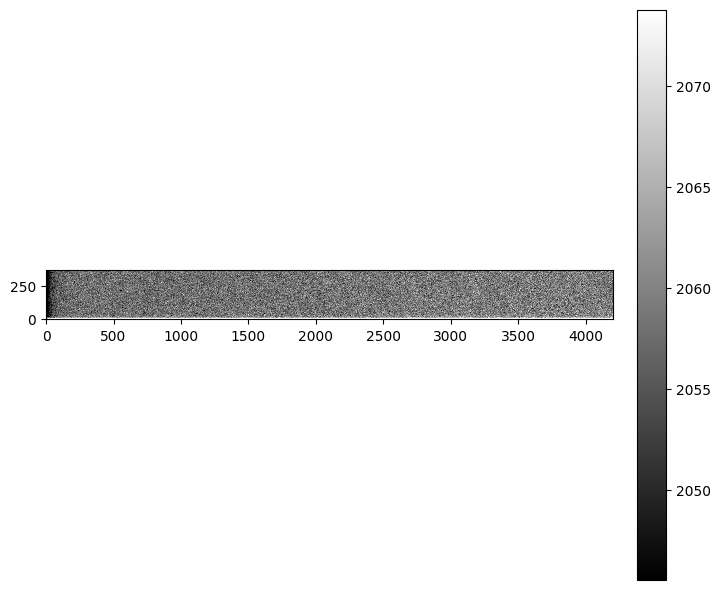

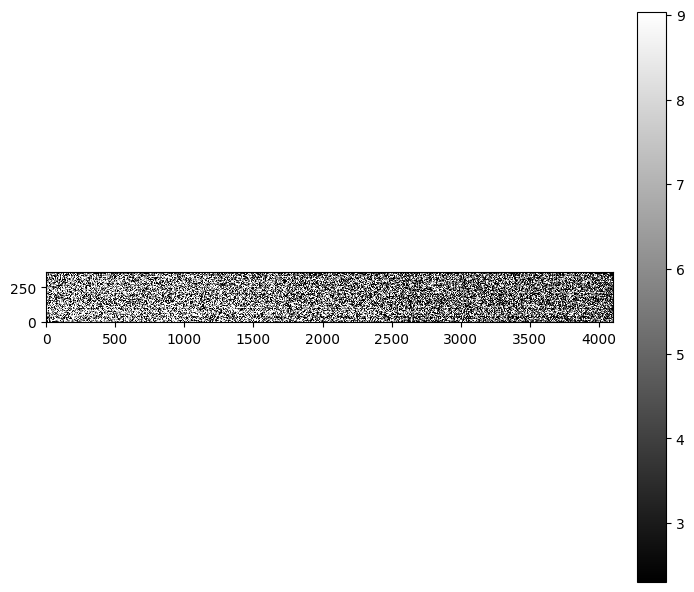

In [42]:
bias_file = '20220916/r1632287.fit'

ccd = CCDData.read(bias_file, hdu=1, unit=u.electron)
plot_image(ccd.data.T)
ccd = ccdproc.subtract_overscan(ccd[::-1], median=True,  overscan_axis=0, fits_section=ccd.header['BIASSEC'])
ccd = ccdproc.trim_image(ccd, ccd.header['TRIMSEC'])
plot_image(ccd.data.T)

### FLAT

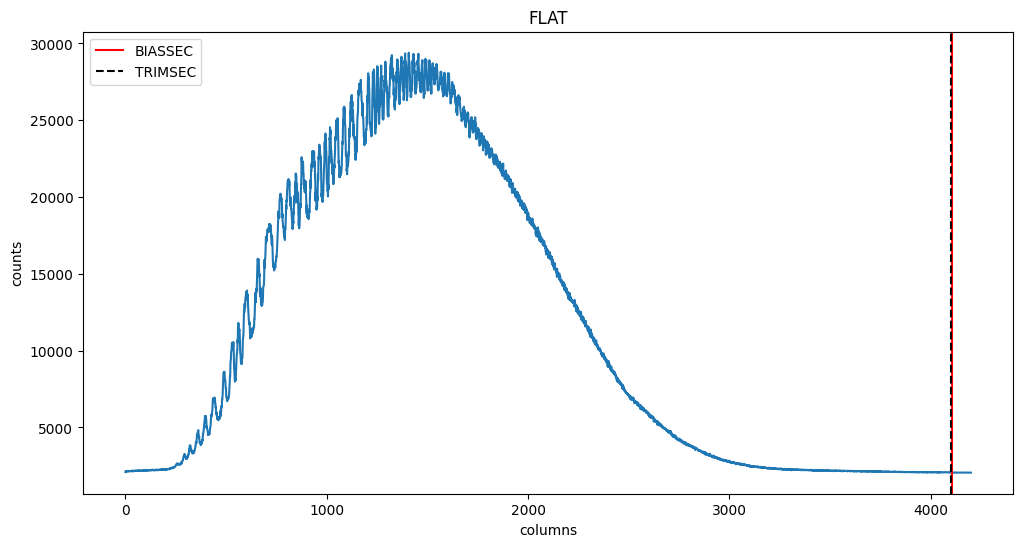

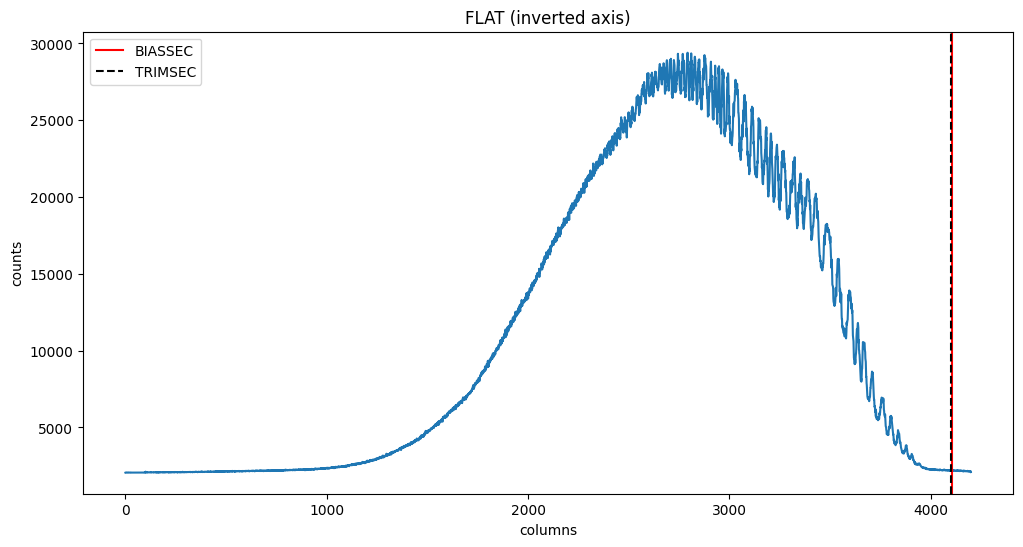

In [45]:
flat_file = '20220916/r1632308.fit'

ccd = CCDData.read(flat_file, hdu=1, unit=u.electron)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ccd.data[:, 150])

biassec = ccd.header['BIASSEC']
biassec_col = int(biassec.split(',')[-1][:4])
trimsec = ccd.header['TRIMSEC']
trimsec_col = int(trimsec.split(',')[-1][2:-1])
ax.axvline(biassec_col, c='r', label='BIASSEC')
ax.axvline(trimsec_col, c='k', ls='--', label='TRIMSEC')
ax.set_xlabel('columns')
ax.set_ylabel('counts')
ax.set_title('FLAT')
ax.legend()

plt.show()

# invert axis
ccd = CCDData.read(flat_file, hdu=1, unit=u.electron)
ccd = ccd[::-1]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ccd.data[:, 150])

biassec = ccd.header['BIASSEC']
biassec_col = int(biassec.split(',')[-1][:4])
trimsec = ccd.header['TRIMSEC']
trimsec_col = int(trimsec.split(',')[-1][2:-1])
ax.axvline(biassec_col, c='r', label='BIASSEC')
ax.axvline(trimsec_col, c='k', ls='--', label='TRIMSEC')
ax.set_xlabel('columns')
ax.set_ylabel('counts')
ax.set_title('FLAT (inverted axis)')
ax.legend()

plt.show()

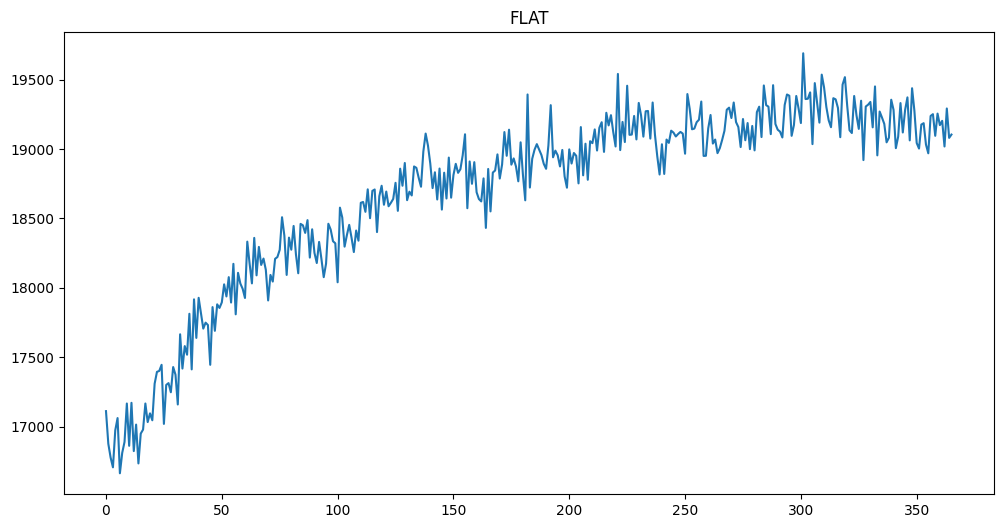

In [163]:
ccd = CCDData.read(flat_file, hdu=1, unit=u.electron)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ccd.data[2000,:])
ax.set_title('FLAT')

plt.show()

the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma.
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma.
Changed DATE-OBS from '2022-09-16        ' to '2022-09-16T00:00:00.0''. [astropy.wcs.wcs]
Changed DATE-OBS from '2022-09-16        ' to '2022-09-16T00:00:00.0''.


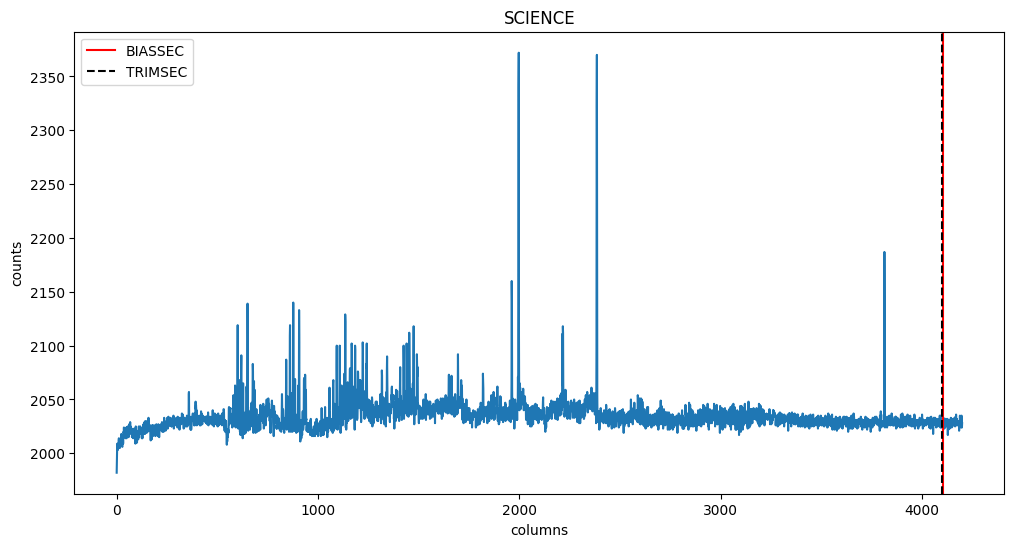

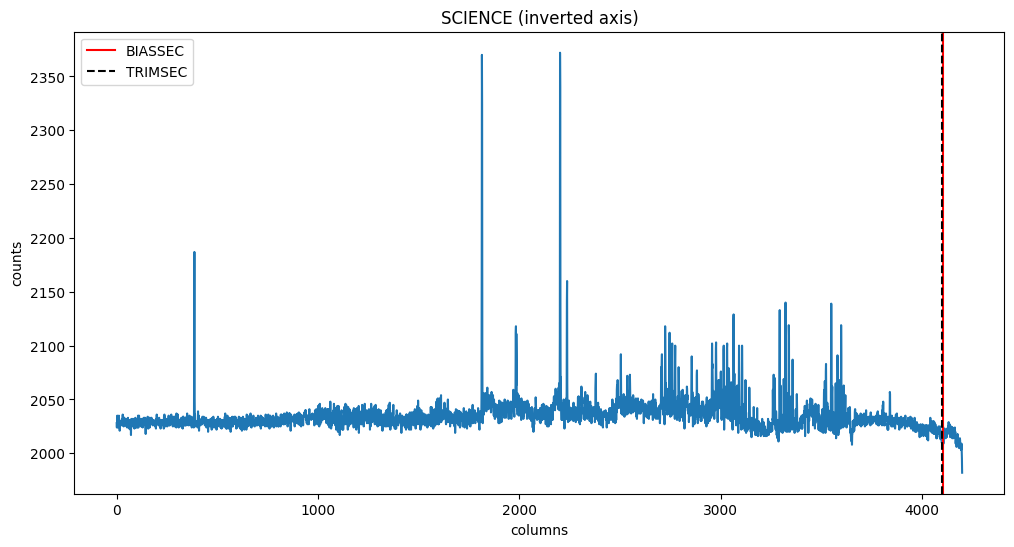

In [45]:
science_file = '20220916/r1632358.fit'

ccd = CCDData.read(science_file, hdu=1, unit=u.electron)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ccd.data[:, 150])

biassec = ccd.header['BIASSEC']
biassec_col = int(biassec.split(',')[-1][:4])
trimsec = ccd.header['TRIMSEC']
trimsec_col = int(trimsec.split(',')[-1][2:-1])
ax.axvline(biassec_col, c='r', label='BIASSEC')
ax.axvline(trimsec_col, c='k', ls='--', label='TRIMSEC')
ax.set_xlabel('columns')
ax.set_ylabel('counts')
ax.set_title('SCIENCE')
ax.legend()

plt.show()

# invert axis
ccd = CCDData.read(science_file, hdu=1, unit=u.electron)
ccd = ccd[::-1]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ccd.data[:, 150])

biassec = ccd.header['BIASSEC']
biassec_col = int(biassec.split(',')[-1][:4])
trimsec = ccd.header['TRIMSEC']
trimsec_col = int(trimsec.split(',')[-1][2:-1])
ax.axvline(biassec_col, c='r', label='BIASSEC')
ax.axvline(trimsec_col, c='k', ls='--', label='TRIMSEC')
ax.set_xlabel('columns')
ax.set_ylabel('counts')
ax.set_title('SCIENCE (inverted axis)')
ax.legend()

plt.show()

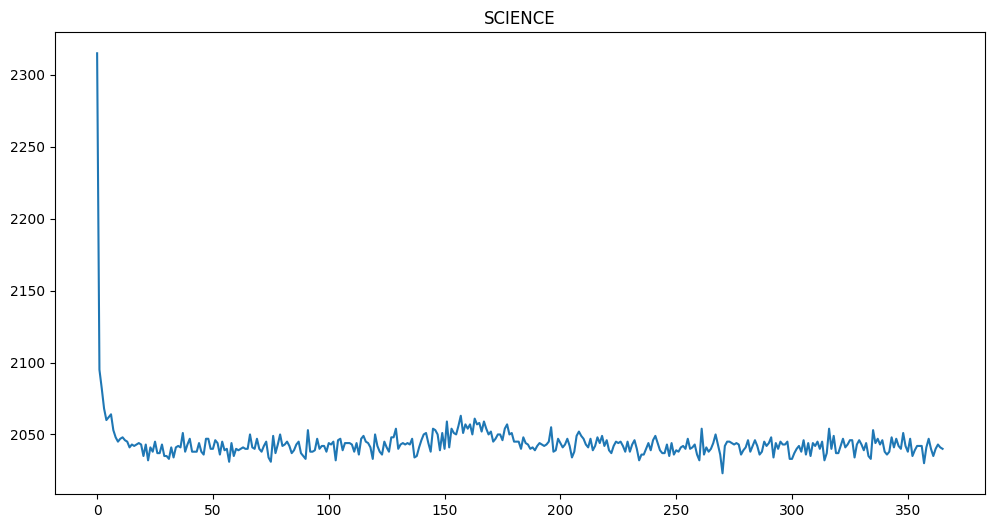

In [164]:
ccd = CCDData.read(science_file, hdu=1, unit=u.electron)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ccd.data[2000,:])
ax.set_title('SCIENCE')

plt.show()

## 2D reduction

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    observations = ImageFileCollection(WORKDIR)

subtract_overscan = True    
trim_image= True
method = 'average'

master_bias = create_master_bias(observations, subtract_overscan, trim_image, method)
master_flat = create_master_flat(observations, master_bias, subtract_overscan, trim_image, method)
red_images = reduce_images(observations, master_bias, master_flat, subtract_overscan, trim_image, method)

INFO:astropy:splitting each image into 8 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 8 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


42 images combined for the master BIAS


INFO:astropy:splitting each image into 6 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 6 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


30 images combined for the master FLAT
Reducing: 2022ESA
20220916/r1632356.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reducing: SN2012DN-CENTER
20220916/r1632358.fit


20220916/r1632360.fit


20220916/r1632362.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reducing: 92-342
20220916/r1632365.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reducing: 2018EBT-CENTER
20220916/r1632367.fit


20220916/r1632370.fit


20220916/r1632372.fit


20220916/r1632374.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reducing: 114-750
20220916/r1632376.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reducing: 2021AESS
20220916/r1632378.fit


20220916/r1632380.fit


20220916/r1632381.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reducing: 98-185
20220916/r1632384.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<AxesSubplot: >

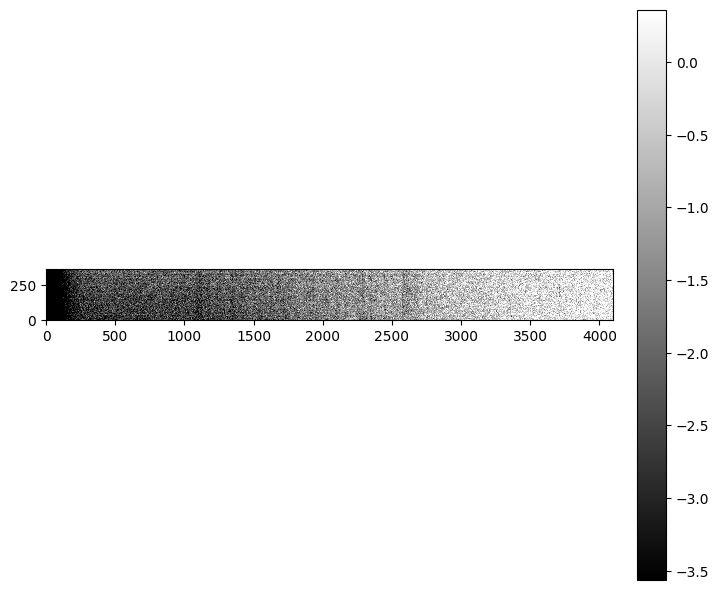

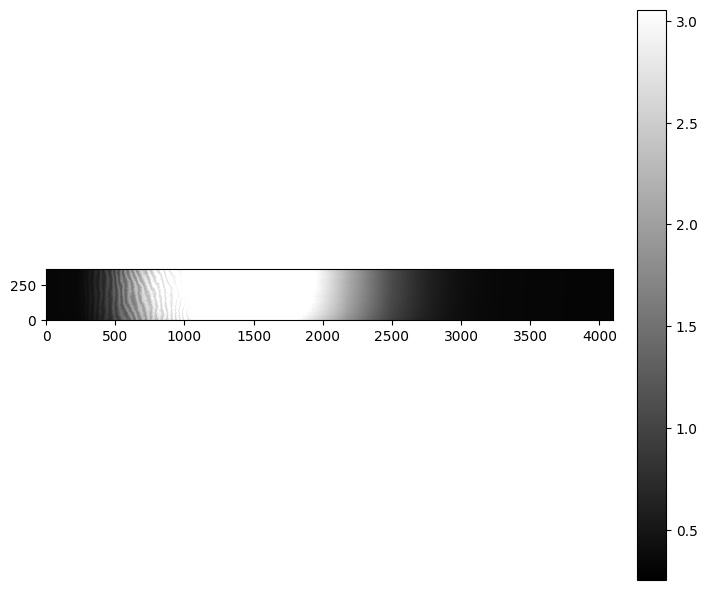

In [18]:
plot_image(master_bias.data.T)
plot_image(master_flat.data.T)

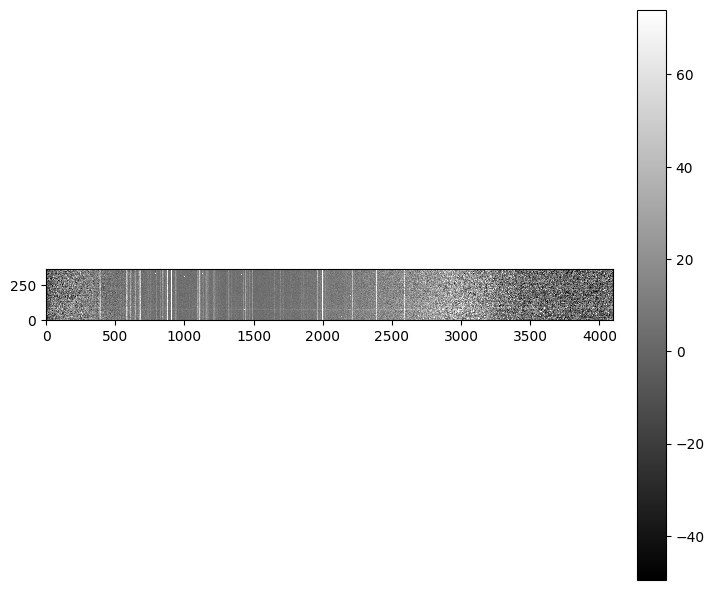

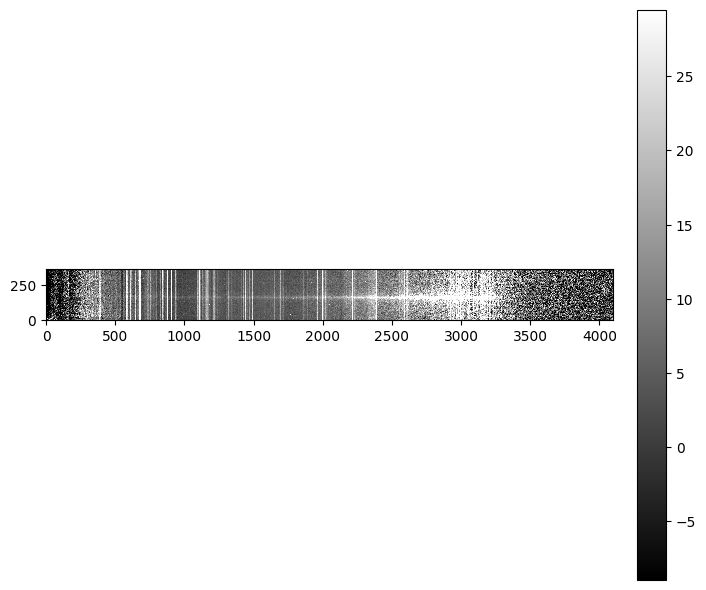

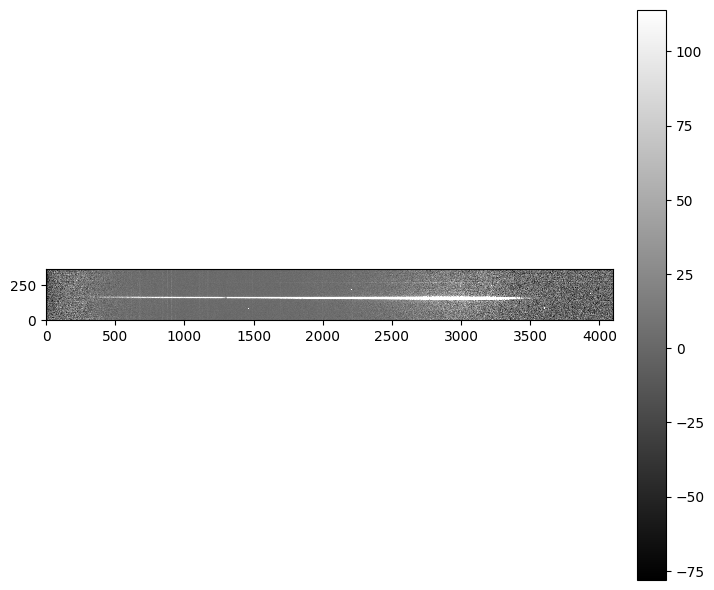

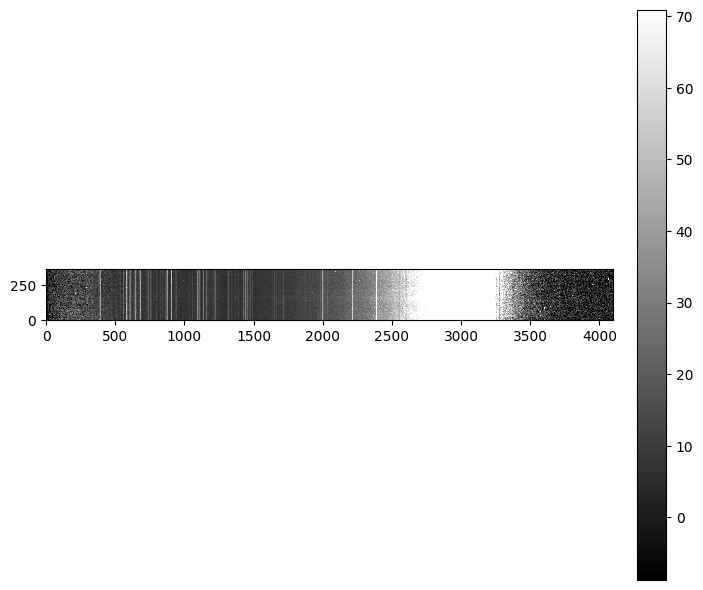

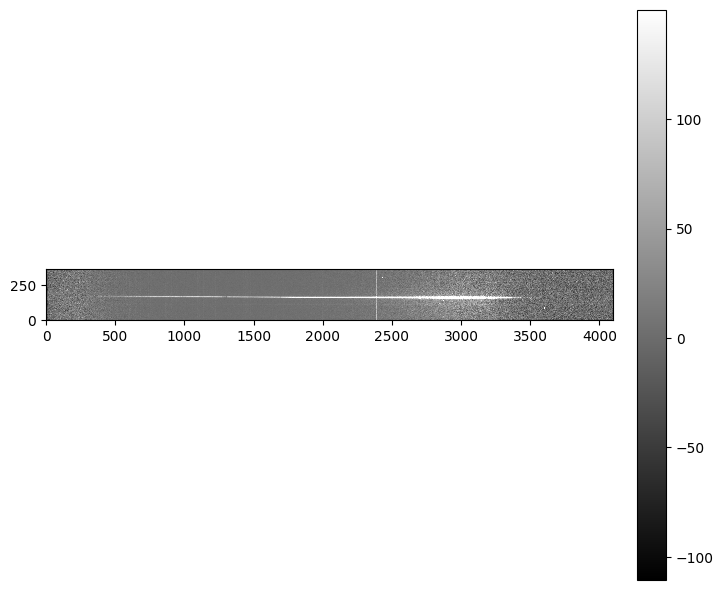

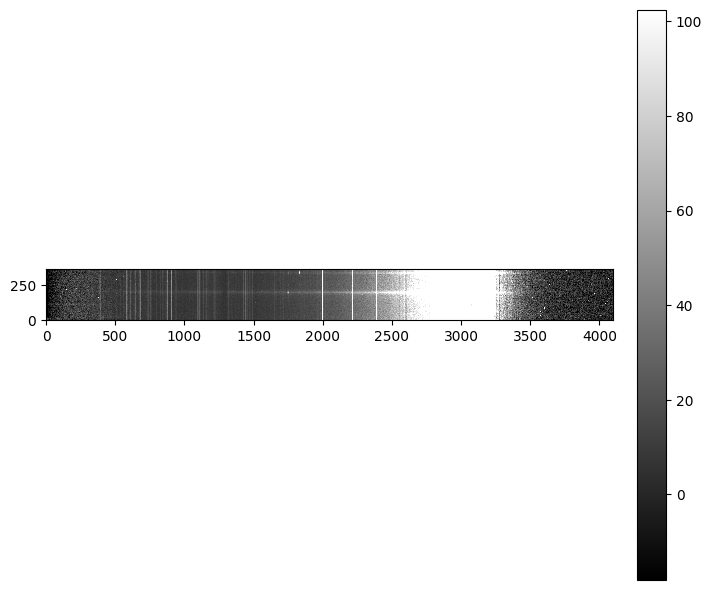

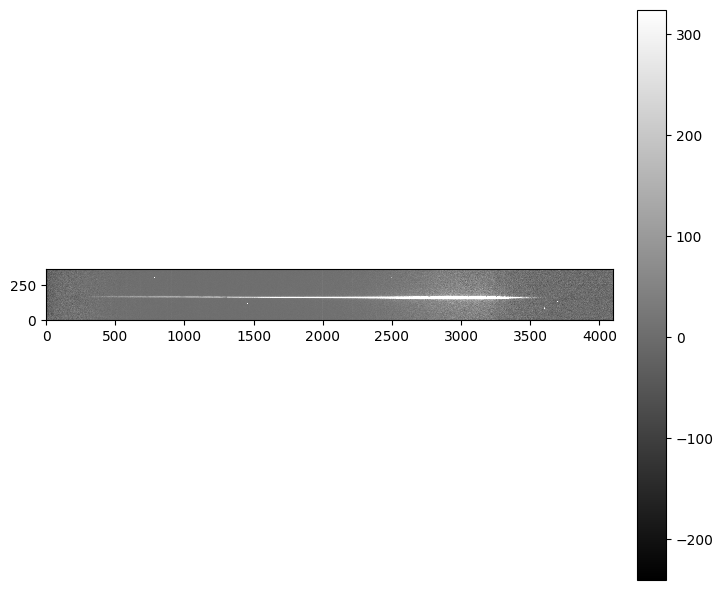

In [19]:
for data in red_images:
    plot_image(data)

## Image Trace

### Simple

In [20]:
def quick_trace(data, center=None, width=50, gap=20, sky_width=20 , plot=False):
    
    if center is None:
        ny, _ = data.shape
        center = ny//2
    
    imin = int(center-width//2)
    imax = int(center+width//2)
    raw_spectrum = np.nansum(data[imin:imax], axis=0)
    
    # sky on one side
    imin_sky1 = int(center-(width//2+gap+sky_width))
    imax_sky1 = int(center-(width//2+gap))
    sky1 = np.nansum(data[imin_sky1:imax_sky1], axis=0)
    
    # sky on the other side
    imin_sky2 = int(center+(width//2+gap))
    imax_sky2 = int(center+(width//2+gap+sky_width))
    sky2 = np.nansum(data[imin_sky2:imax_sky2], axis=0)
    
    # sky subtraction
    sky = np.nanmean(sky1 + sky2, axis=0)
    raw_spectrum -= sky
    
    if plot:
        ax = plot_image(data)
        ax.axhline(imin, c='r', lw=1)
        ax.axhline(imax, c='r', lw=1)
        
        ax.axhline(imin_sky1, c='r', ls='dotted', lw=1)
        ax.axhline(imax_sky1, c='r', ls='dotted', lw=1)
        
        ax.axhline(imin_sky2, c='r', ls='dotted', lw=1)
        ax.axhline(imax_sky2, c='r', ls='dotted', lw=1)
        plt.show()
    
    return raw_spectrum[::-1]  # the axis is inverted

Reducing: 2022ESA


Reducing: SN2012DN-CENTER


Reducing: 92-342


Reducing: 2018EBT-CENTER



Reducing: 114-750


Reducing: 2021AESS


Reducing: 98-185


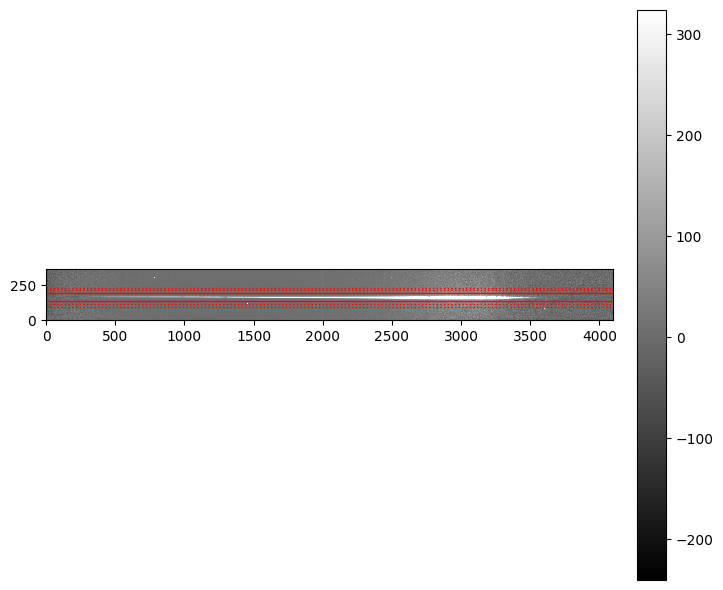

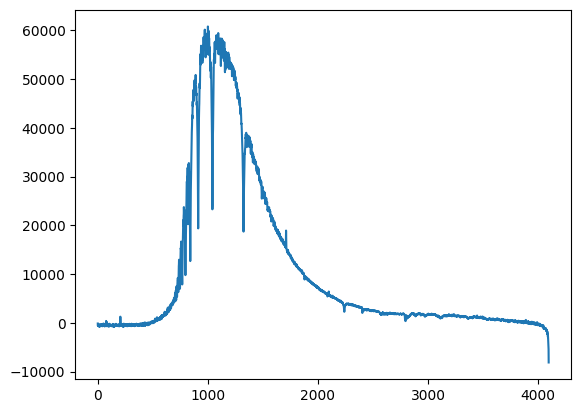

In [24]:
#raw_spectrum = quick_trace(red_images[0].data, center=80, width=30, plot=True) 
raw_spectrum = quick_trace(red_images[-1].data, center=165, width=60, plot=True)
#raw_spectrum = quick_trace(red_images[-3].data, center=170, width=40, plot=True)
plt.plot(raw_spectrum+100)

### Proper

In [25]:
def get_profile_model(params, ys):
    amplitude, center, sigma = params
    
    profile = np.exp(-(ys - center)**2 / 2 / sigma**2) 
    profile /= profile.max()

    return amplitude*profile

def get_profile_model(params, ys):
    amplitude, center, sigma, yoffset = params
    
    profile = np.exp(-(ys - center)**2 / 2 / sigma**2) 
    profile /= profile.max()

    return amplitude*profile + yoffset

def get_profile_chisq(params, ys, profile):
    model = get_profile_model(params, ys)
    
    return np.sum( (profile - model)**2 / profile.size - len(params))

def calc_trace(data, center=None, amp=None, hwidth=50, t_order=3, plot_diag=False, plot_trace=True):
    
    ny, nx = data.shape
    cy, cx = ny//2, nx//2
    xs = np.arange(nx)
    ys = np.arange(ny)
    yvals, xvals = np.indices(data.shape)
    
    cols = np.arange(hwidth, nx + 1, 2 * hwidth)
    ycenter = np.zeros(len(cols))
    ywidth = np.zeros(len(cols))
    init_sky = np.zeros(len(cols))
    
    for icol, col in enumerate(cols):
        stamp = data[:, col - hwidth : col + hwidth]
        profile = np.nanmean(stamp, axis=1)

        if center is None or amp is None:
            peaks = find_peaks(profile, height=np.nanmedian(profile), width=10)[0]
            amp = np.max(profile[peaks])
            peak_id = np.argmax(profile[peaks])
            center = peaks[peak_id]
        #guess = (amp, center, 5)
        guess = (amp, center, 5, np.nanmedian(profile))
        
        params = fmin(get_profile_chisq, guess, args=(ys, profile), disp=False)
        if params[2] < 20:
            ycenter[icol] = params[1]
            ywidth[icol] = 4*params[2]
            init_sky[icol] = 5*params[2]
            model = get_profile_model(params, ys)

            if plot_diag:
                fig, ax = plt.subplots(figsize=(12, 6))
                ax.plot(ys, profile, label='data')
                ax.plot(ys, model, label='model')
                ax.axvline(ycenter[icol]+ywidth[icol], c='r', ls='dotted', label='aperture')
                ax.axvline(ycenter[icol]-ywidth[icol], c='r', ls='dotted')
                ax.axvspan(ycenter[icol]+init_sky[icol], ycenter[icol]+init_sky[icol]+20, 
                           alpha=0.3, color='red', label='sky')
                ax.axvspan(ycenter[icol]-init_sky[icol], ycenter[icol]-init_sky[icol]-20, 
                           alpha=0.3, color='red')
                ax.set_xlabel('Row Number')
                ax.set_ylabel('Median Row Counts')
                ax.legend()
                plt.grid();
                plt.show()
        else:
            ycenter[icol] = np.inf
            ywidth[icol] = np.inf
            init_sky[icol] = np.inf
    
    # remove bad fits
    mask = np.isfinite(ycenter)
    ycenter = ycenter[mask]
    ywidth = ywidth[mask]
    init_sky = init_sky[mask]
    cols = cols[mask]
    
    # remove untrusted fits
    mask = ~sigma_clip(ycenter, maxiters=10).mask
    ycenter = ycenter[mask]
    ywidth = ywidth[mask]
    init_sky = init_sky[mask]
    cols = cols[mask]

    trace_coef = np.polyfit(cols, ycenter, t_order)
    trace = np.polyval(trace_coef, xs)
    
    # aperture
    trace_coef_top = np.polyfit(cols, ycenter+ywidth, t_order)
    #trace_top = np.polyval(trace_coef_top, xs)
    trace_top = trace+ywidth.mean()
    trace_coef_bottom = np.polyfit(cols, ycenter-ywidth, t_order)
    #trace_bottom = np.polyval(trace_coef_bottom, xs)
    trace_bottom = trace-ywidth.mean()
    
    # aperture
    sky_coef_top = np.polyfit(cols, ycenter+init_sky, t_order)
    #sky_top = np.polyval(sky_coef_top, xs)
    sky_top = trace+init_sky.mean()
    sky_coef_bottom = np.polyfit(cols, ycenter-init_sky, t_order)
    #sky_bottom = np.polyval(sky_coef_bottom, xs)
    sky_bottom = trace-init_sky.mean()

    if plot_diag:
        fig, ax = plt.subplots(2, figsize=(12, 6), sharex=True)
        ax[0].plot(cols, ycenter, 'ro', label='data')
        ax[0].plot(xs, trace, 'r', label='spline')
        ax[0].plot(xs, trace_top, 'r', ls='--', label='aperture')
        ax[0].plot(xs, trace_bottom, 'r', ls='--')
        ax[0].set_title('Trace')
        ax[0].axes.set_ylabel('y-coordinate')
        ax[0].legend()
        ax[0].grid()

        trace_col = np.polyval(trace_coef, cols)
        ax[1].plot(cols, ycenter - trace_col, 'ro')
        ax[1].axhline(0.0, c='k')
        ax[1].axes.set_ylabel('Fit Residual (pixels)')
        ax[1].set_xlabel('Column Number')
        ax[1].grid()
        plt.show()
    
    if plot_trace:
        ax = plot_image(data)
        #ax.plot(xs, trace-trace_width//2, c='r')
        #ax.plot(xs, trace+trace_width//2+1, c='r')
        ax.plot(xs, trace_top, c='r')
        ax.plot(xs, trace_bottom, c='r')
        plt.show()
        
    raw_spectrum = np.zeros_like(trace)
    for i in xs:
        # sky
        imin = int(sky_bottom[i]-20)
        imax = int(sky_bottom[i])
        sky1 = np.nansum(data[imin:imax,i])
        
        imin = int(sky_top[i])
        imax = int(sky_top[i]+20)
        sky2 = np.nansum(data[imin:imax,i])
        
        sky = np.mean(sky1 + sky2)
        
        #imin = int(trace[i]-trace_width//2)
        #imax = int(trace[i]+trace_width//2+1)
        imin = int(trace_bottom[i])
        imax = int(trace_top[i])
        raw_spectrum[i] = np.nansum(data[imin:imax,i]) - sky  # with background subtraction
        
    
    return raw_spectrum[::-1]  # the axis is inverted

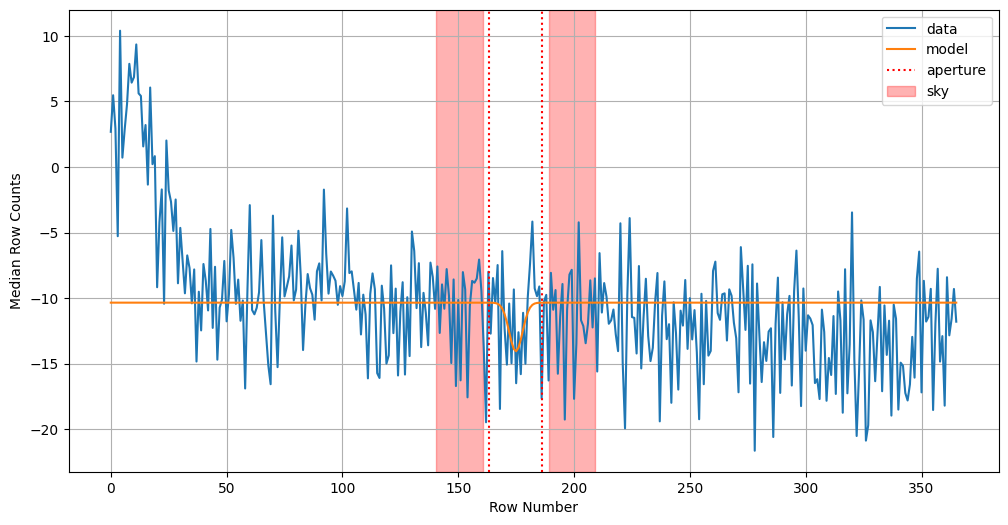

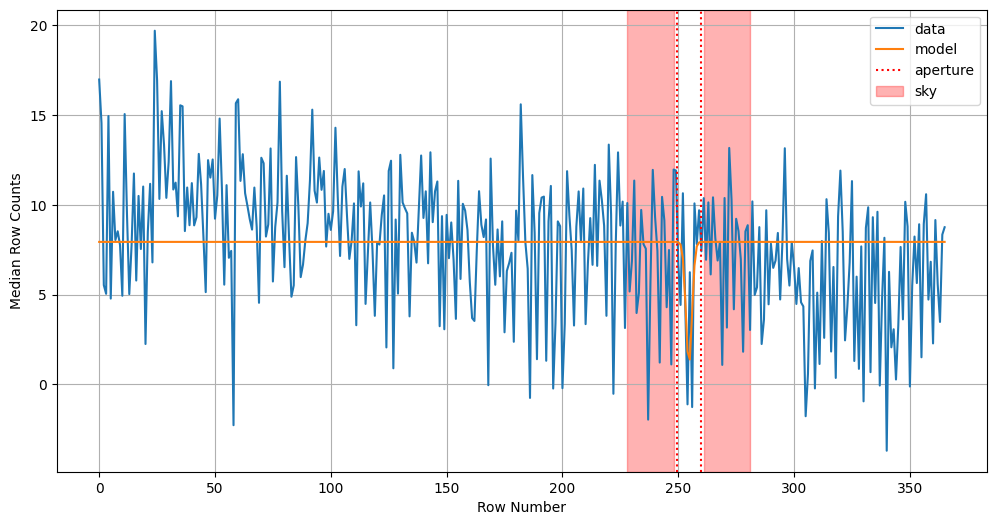

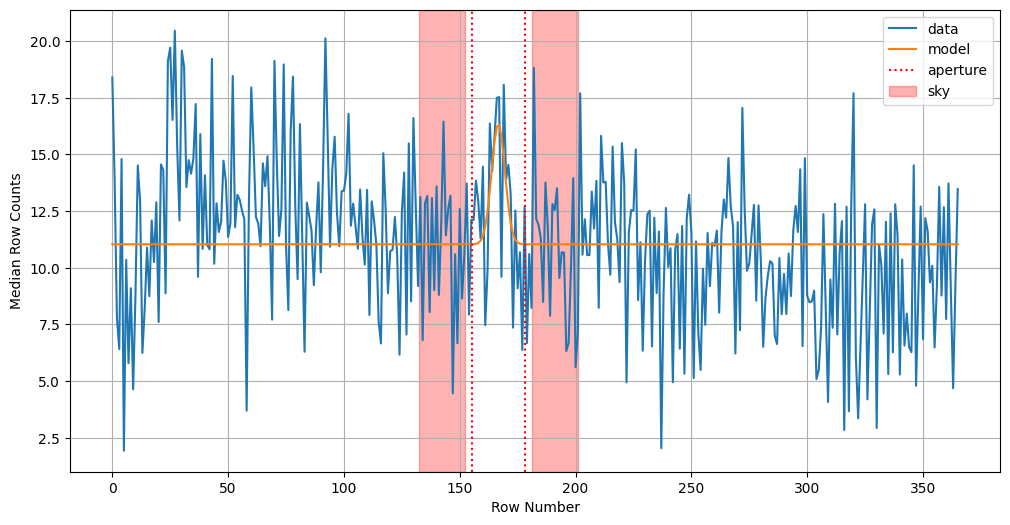

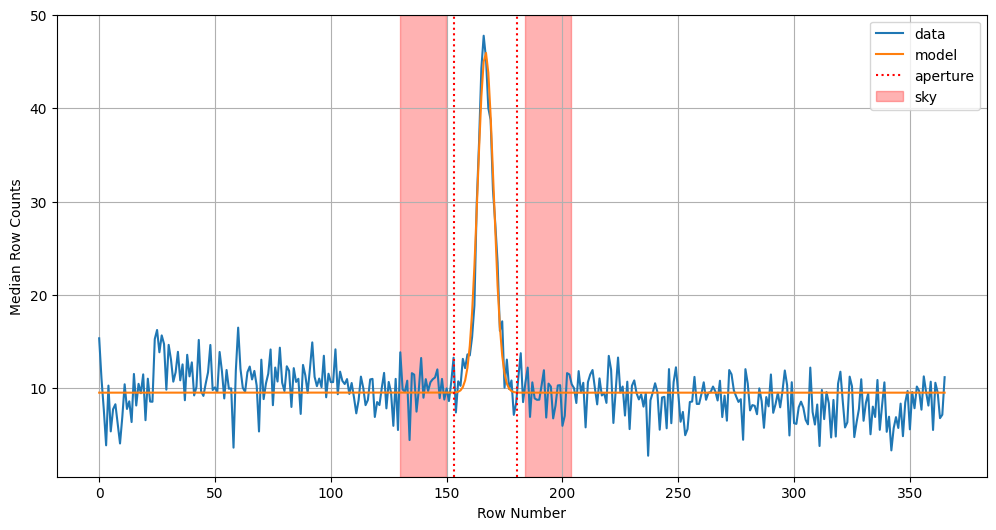

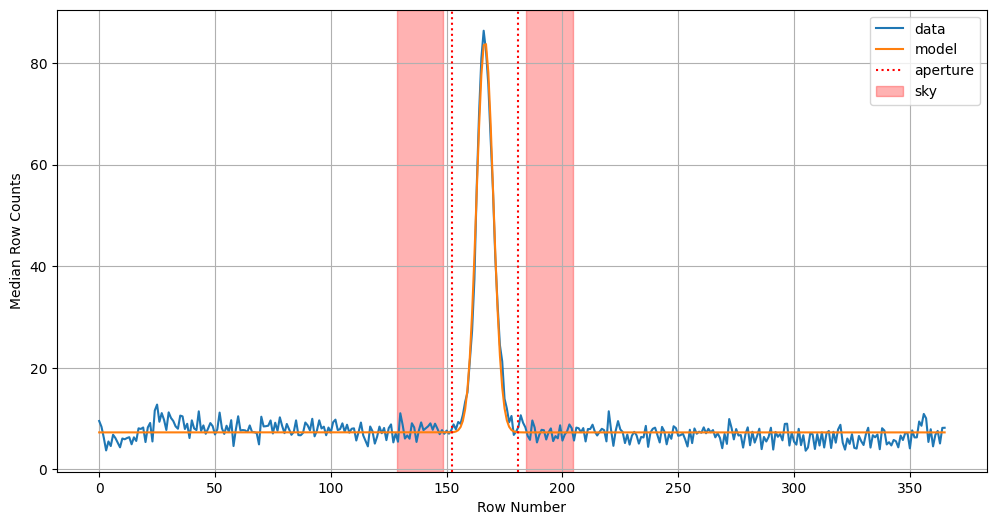

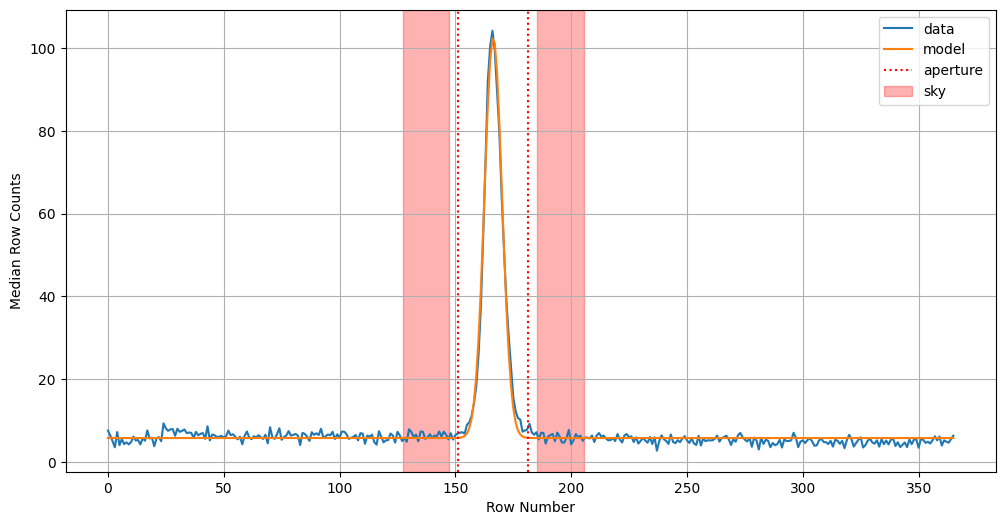

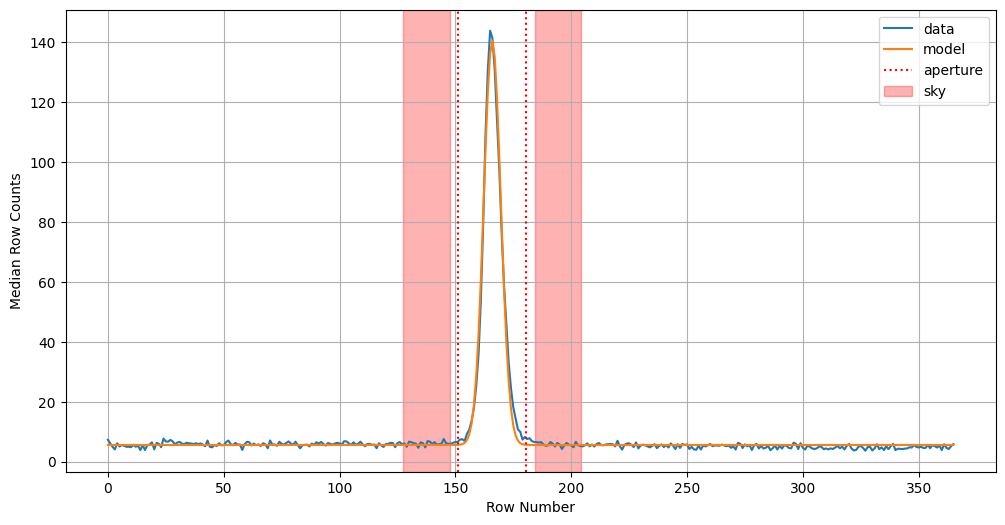

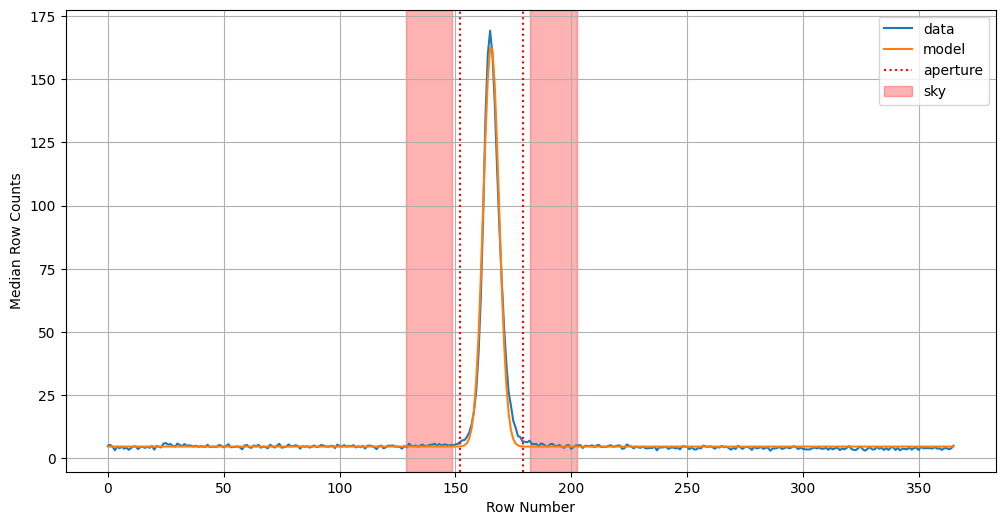

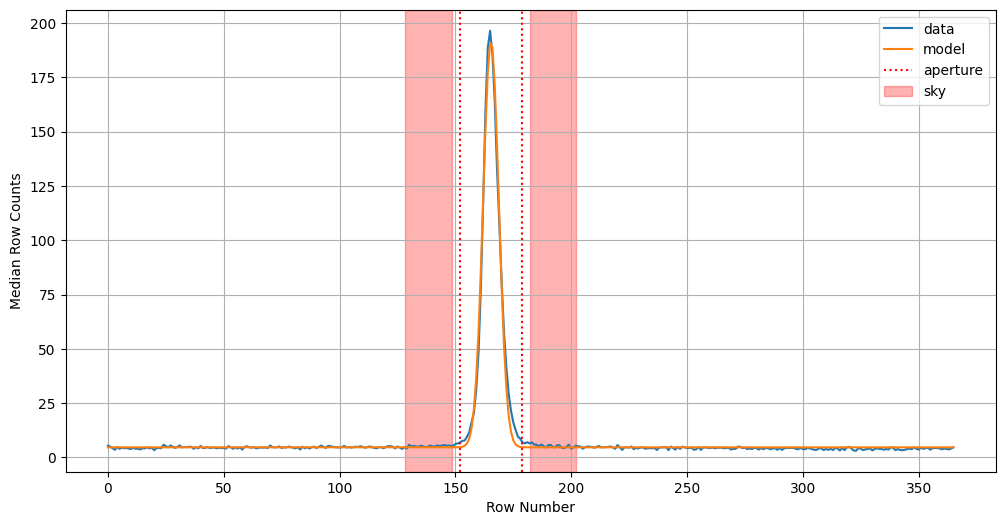

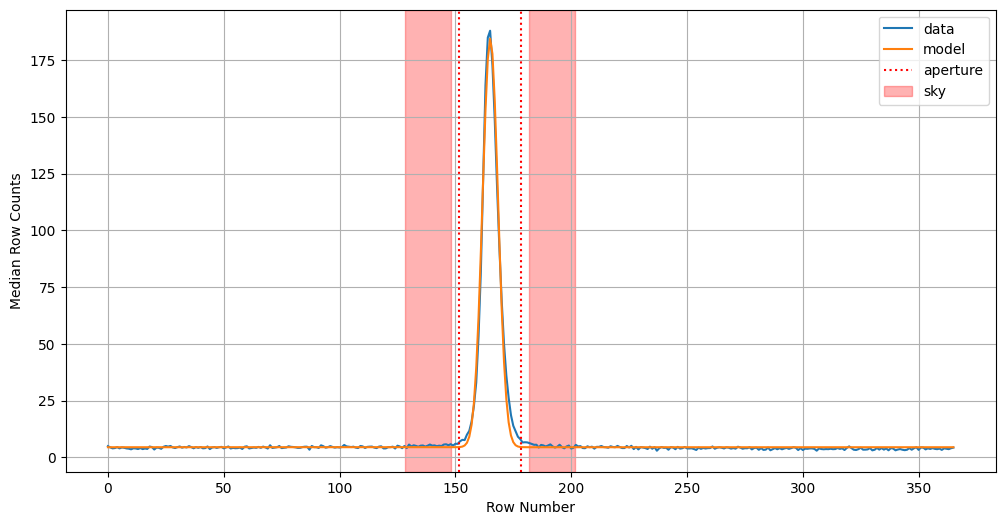

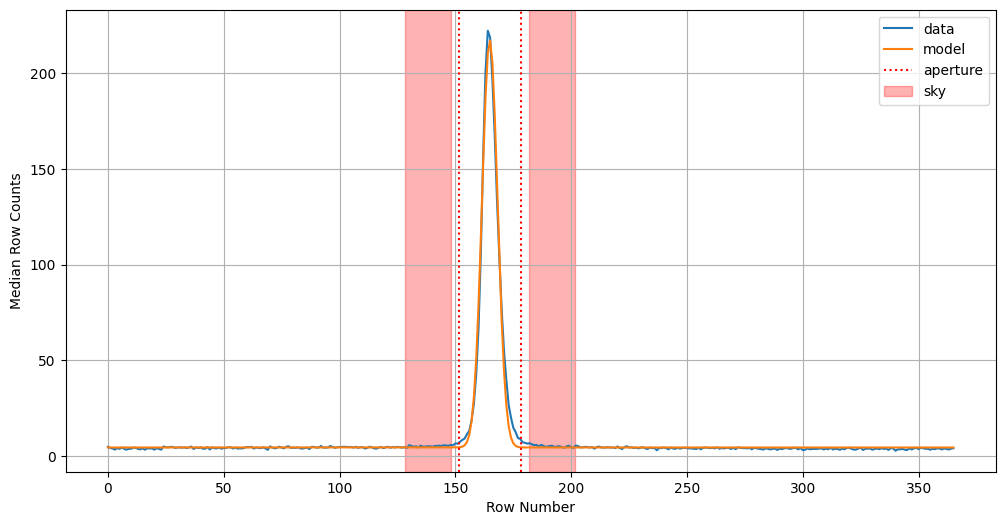

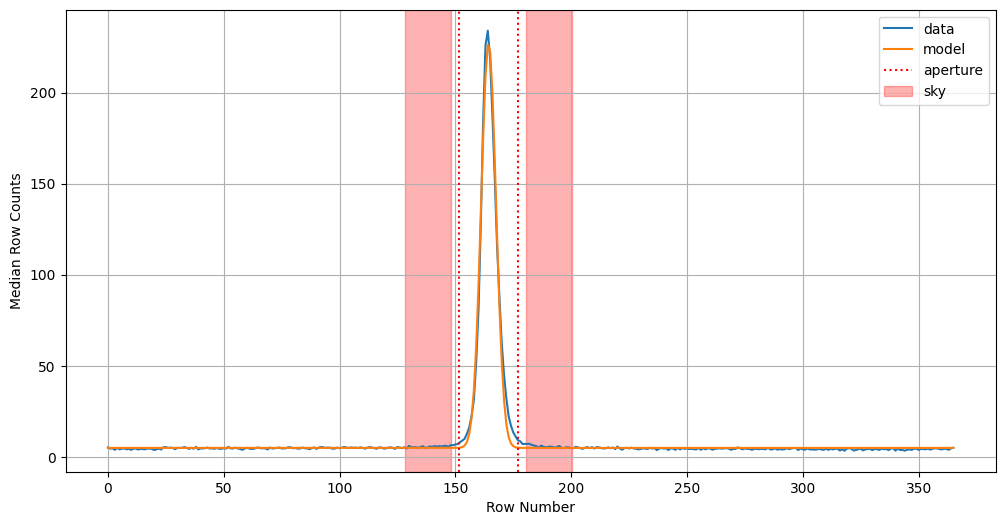

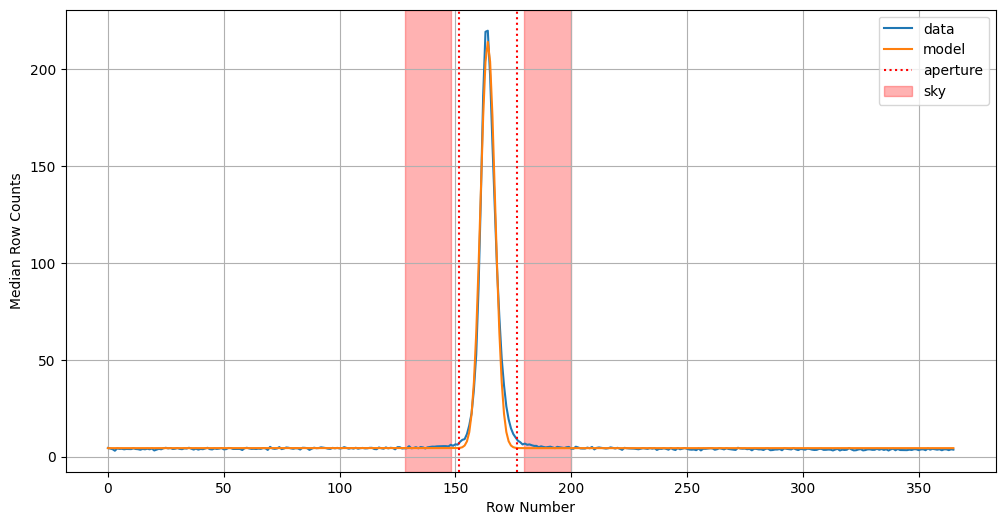

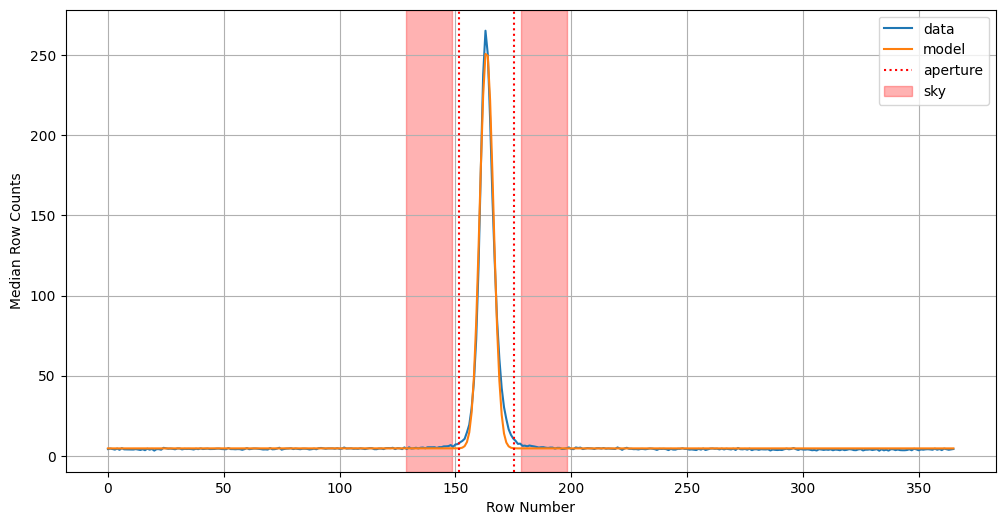

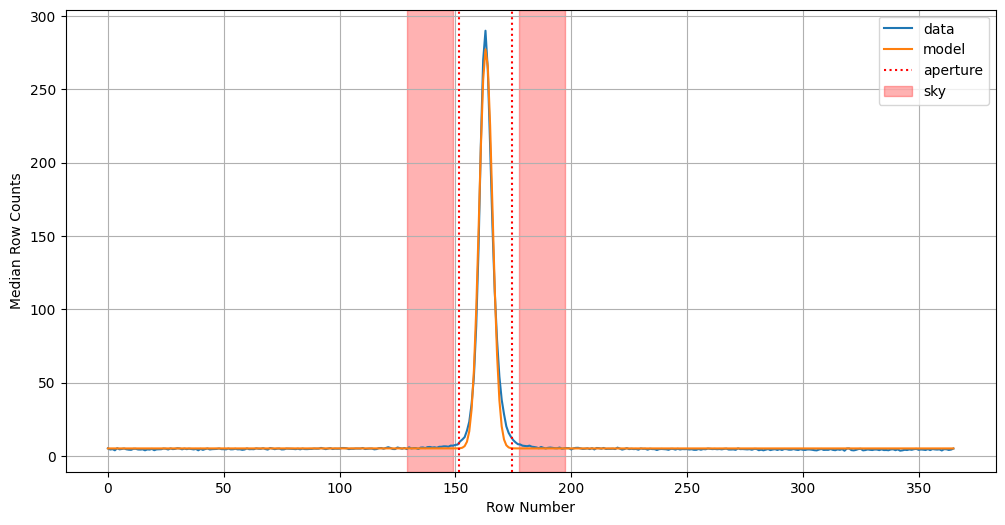

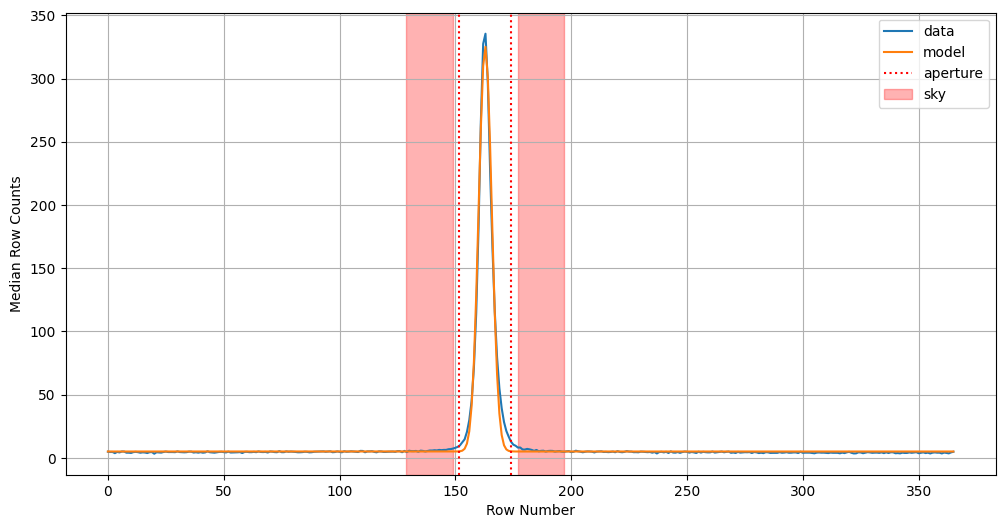

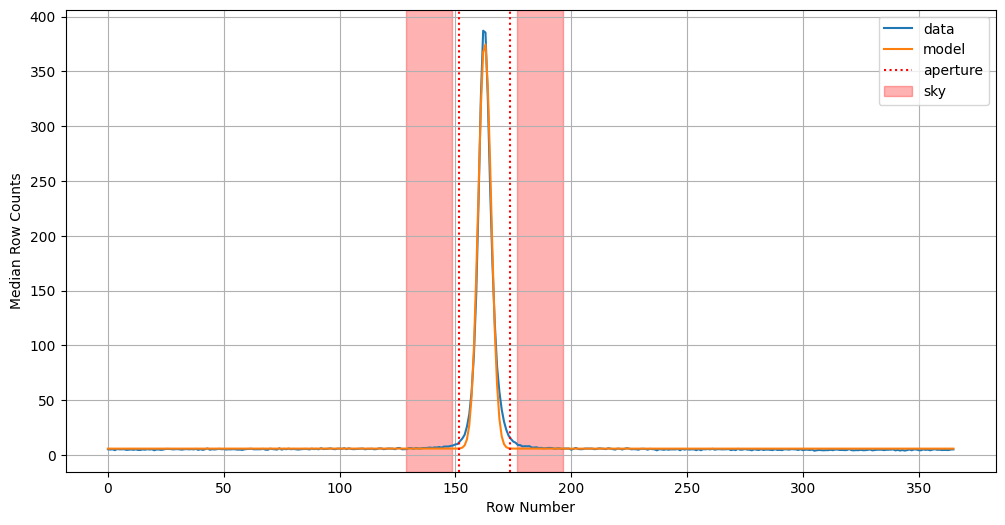

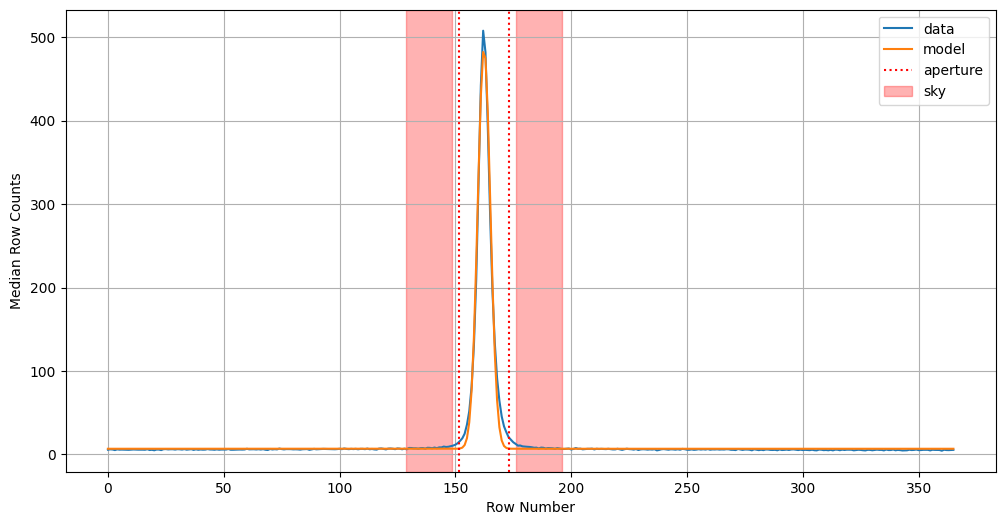

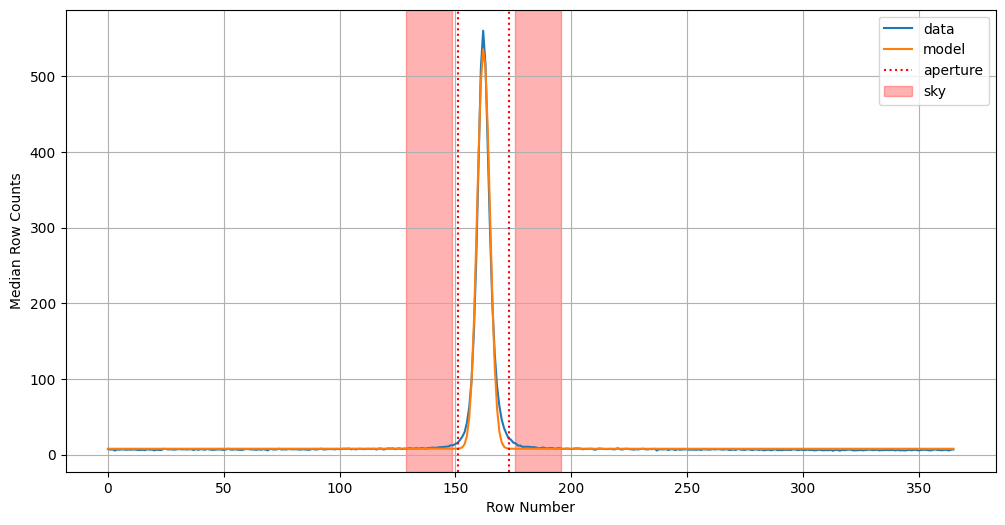

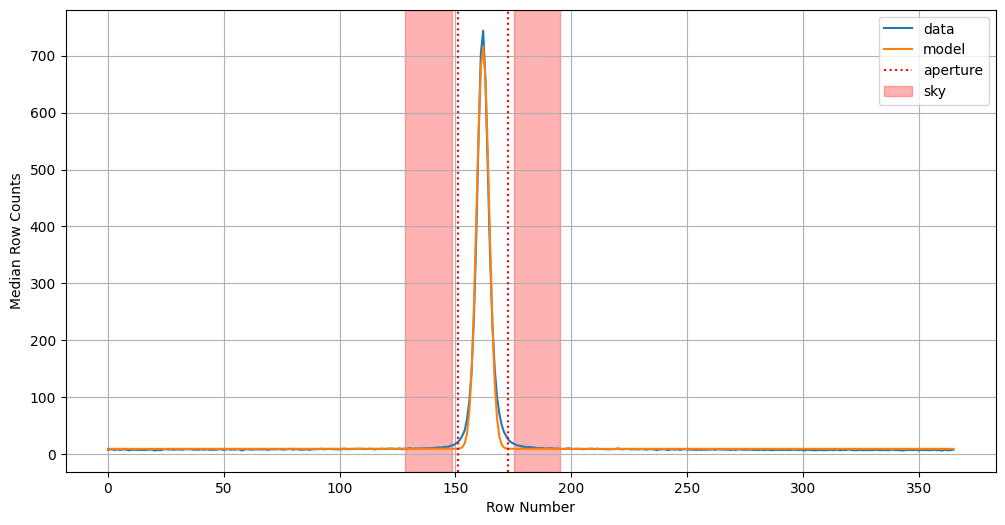

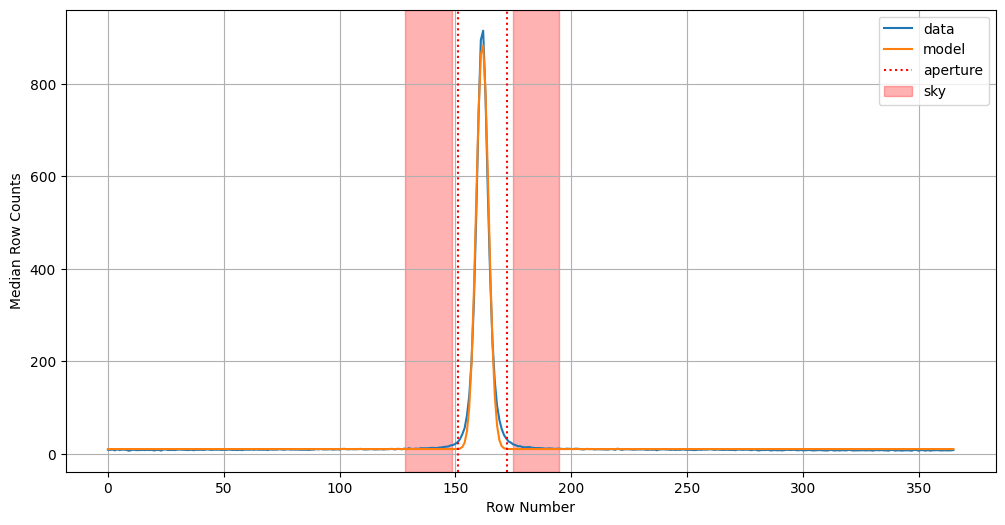

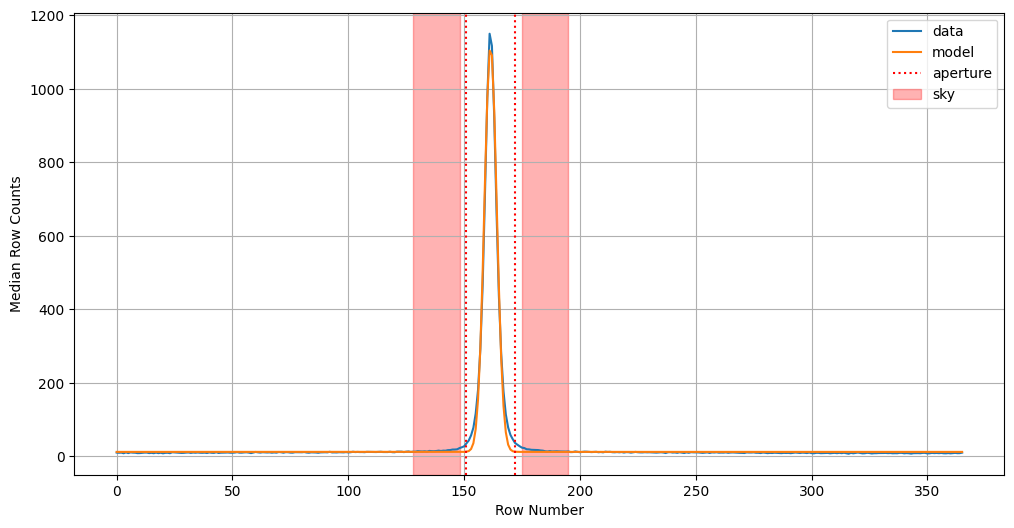

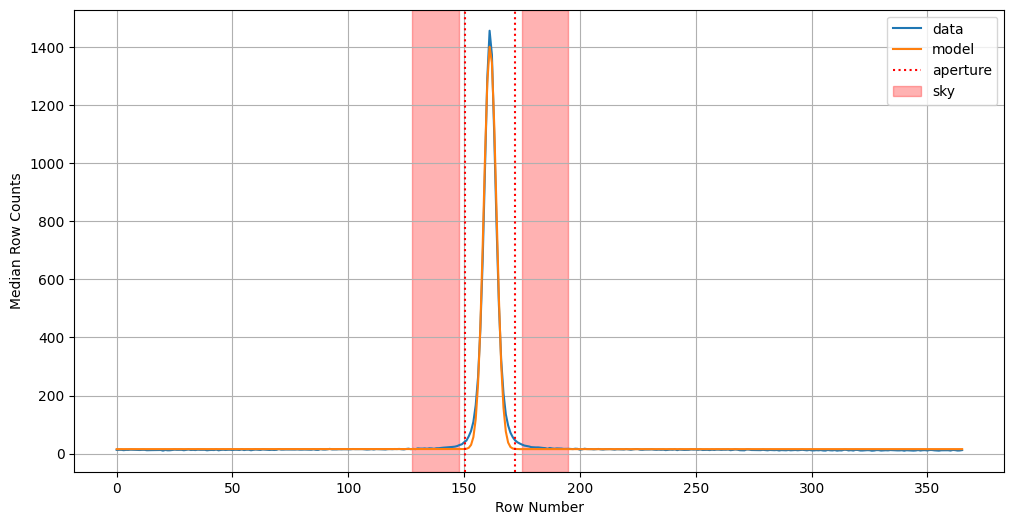

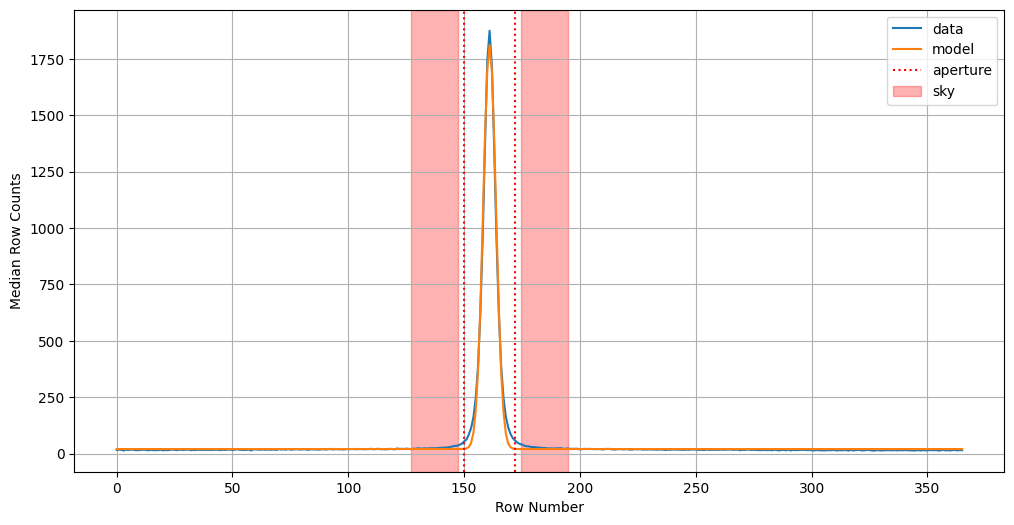

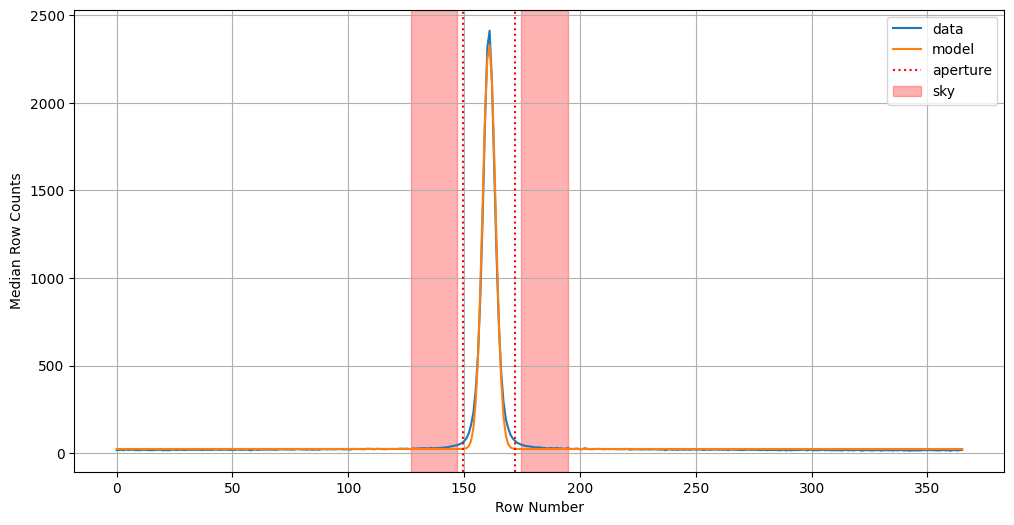

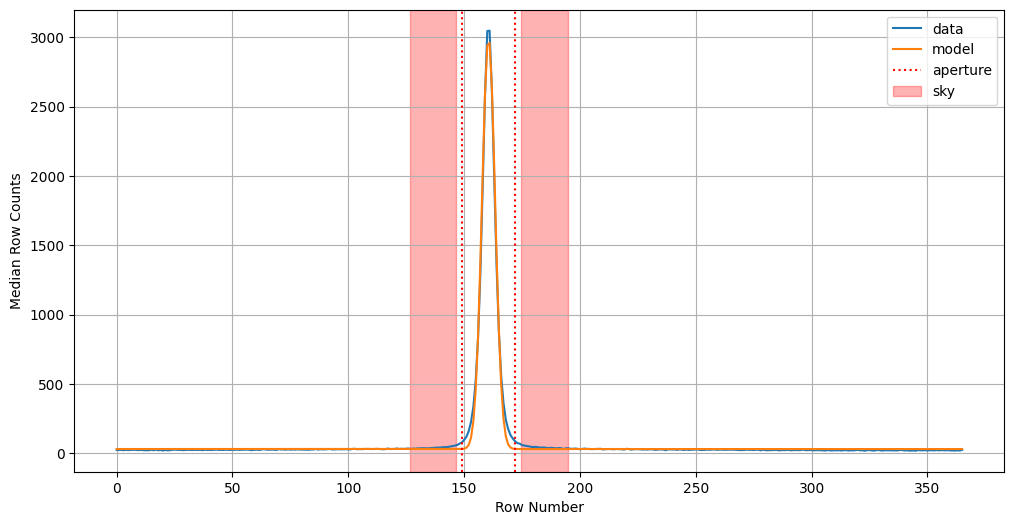

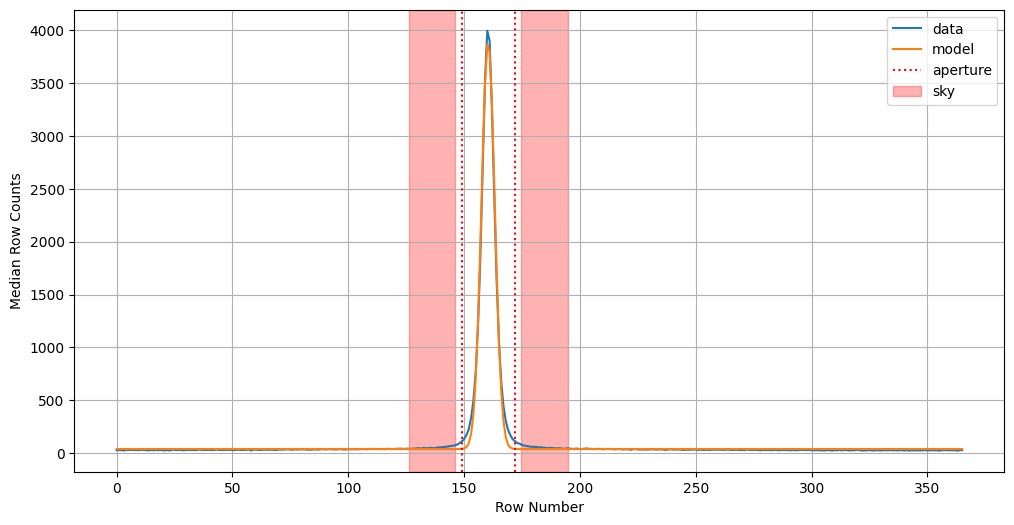

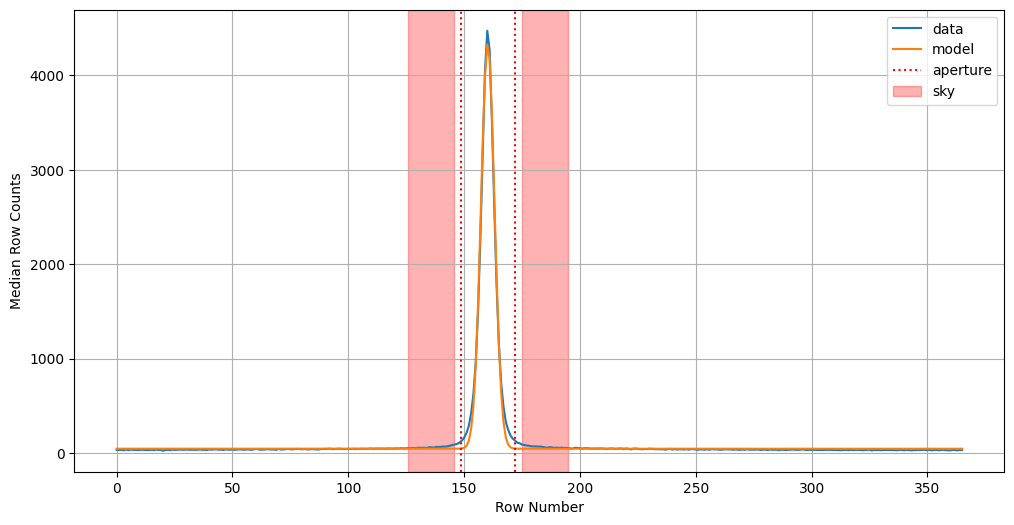

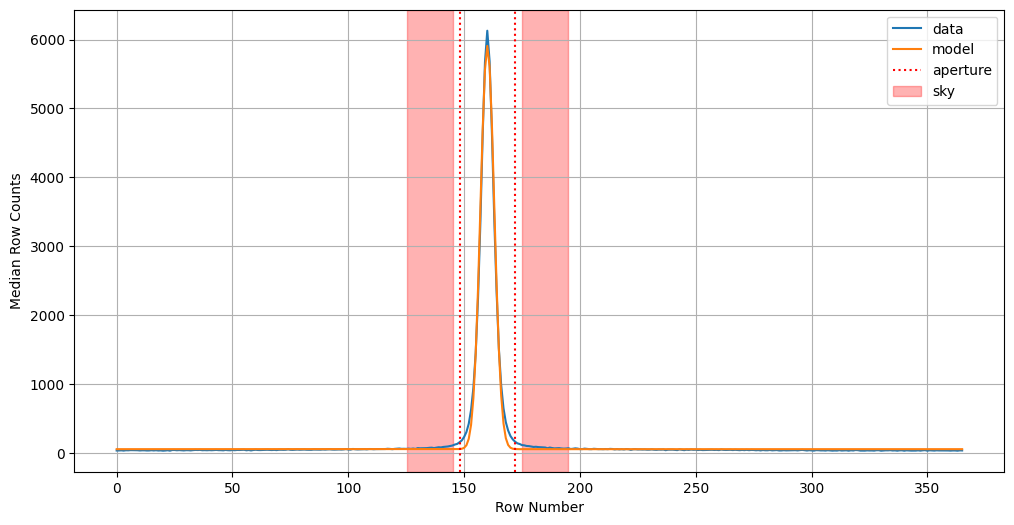

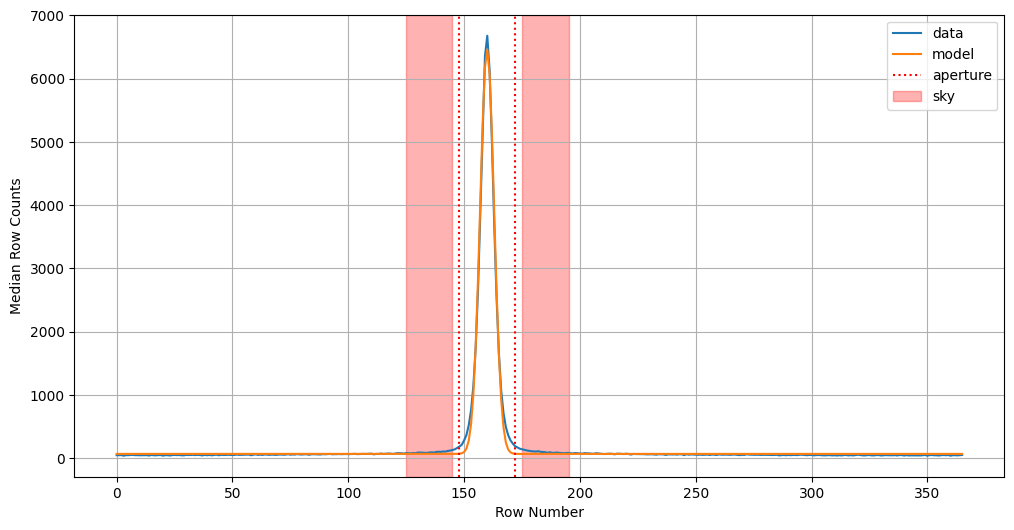

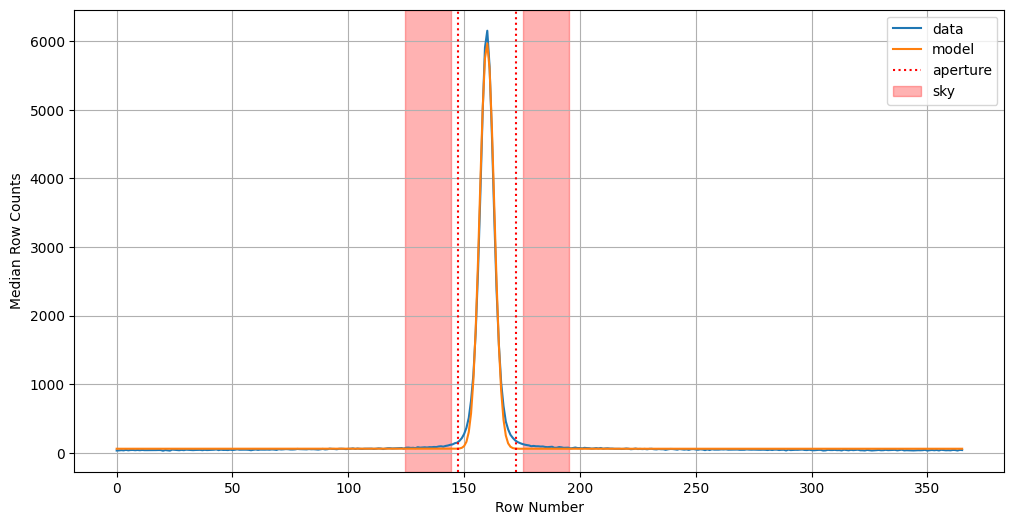

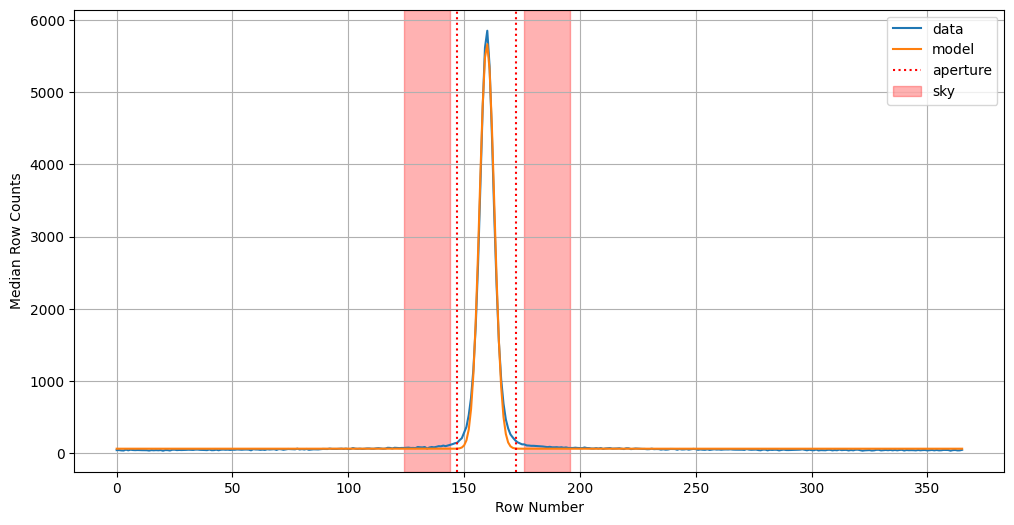

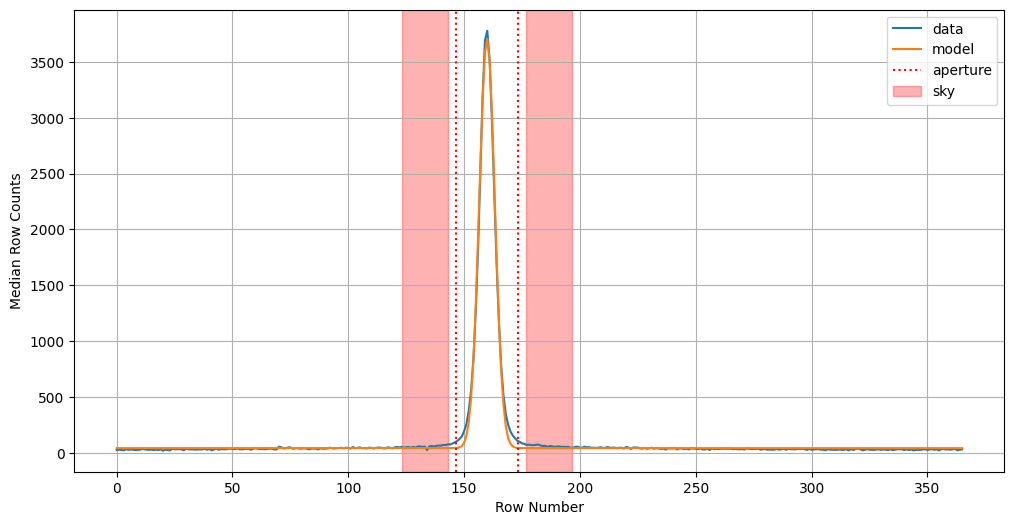

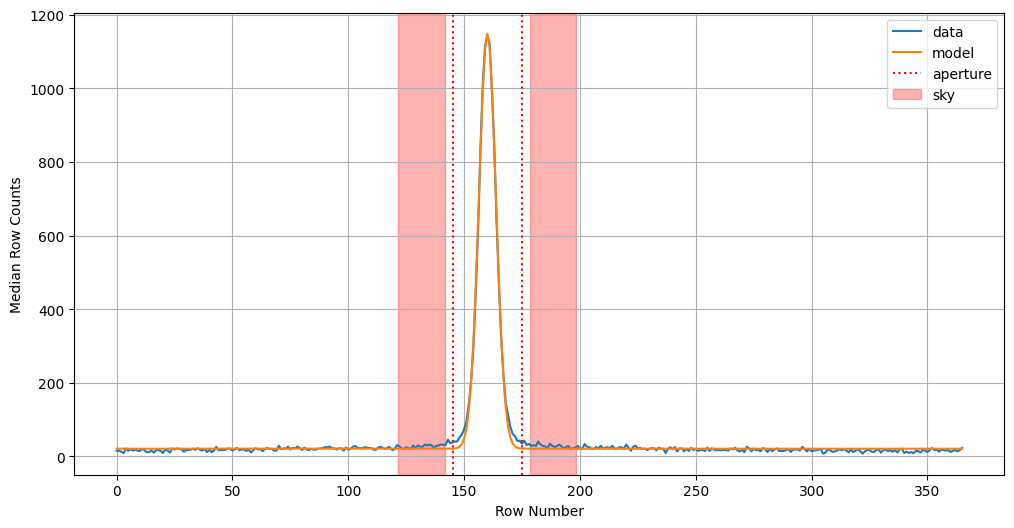

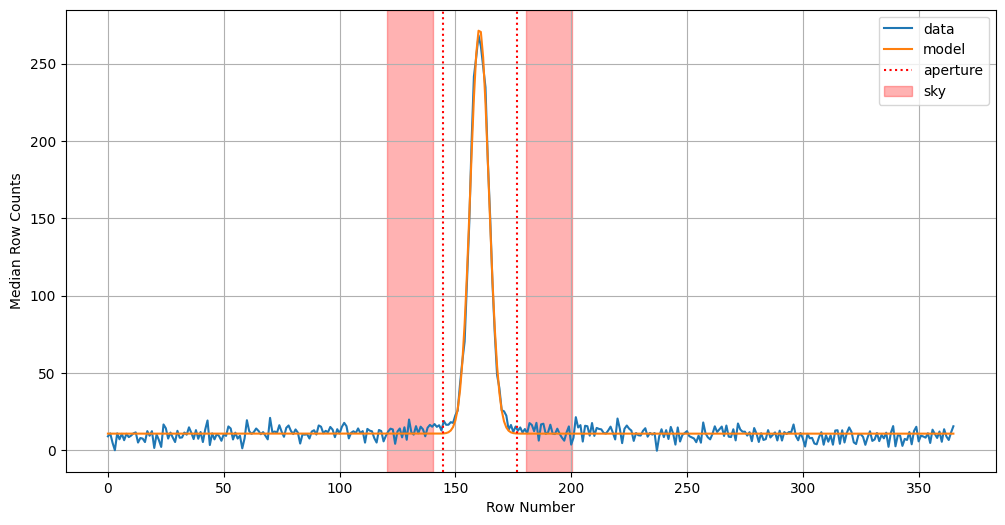

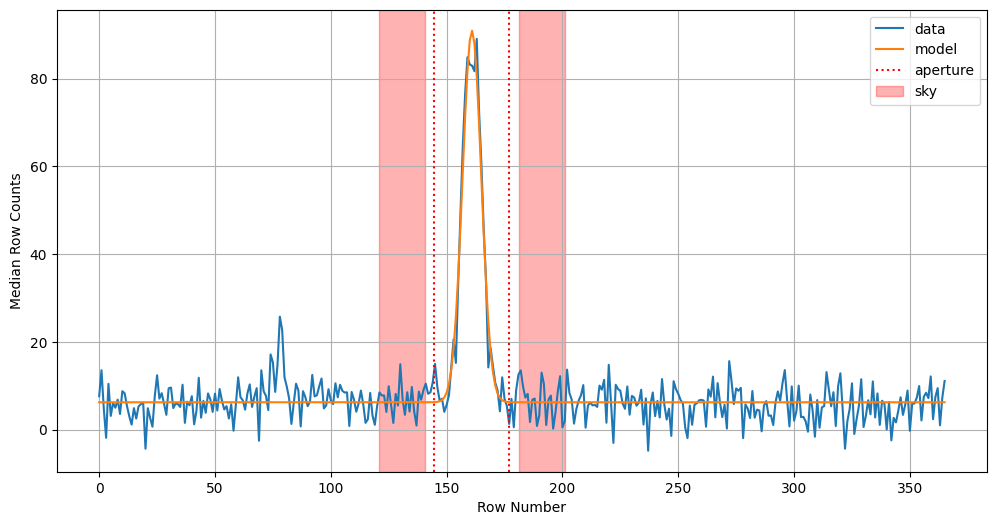

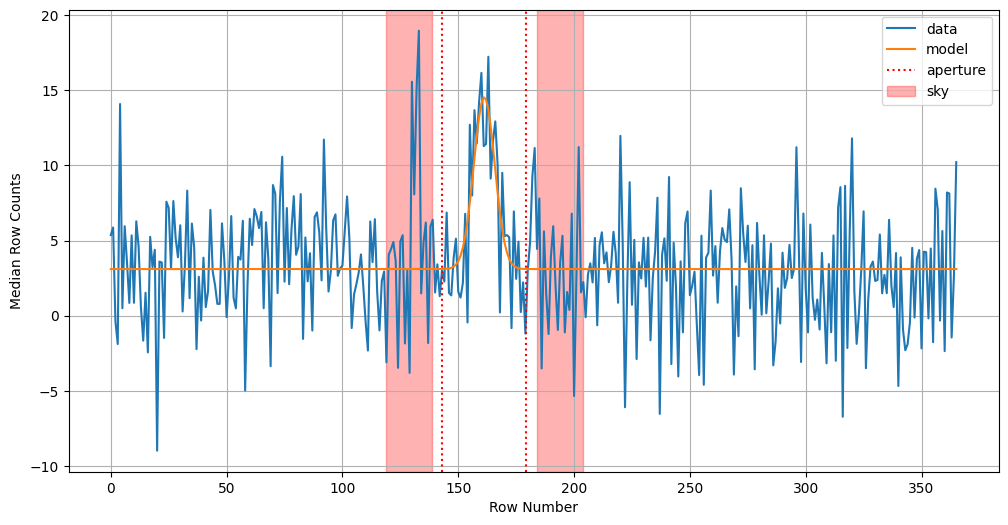

/tmp/ipykernel_24579/885101656.py:13: RuntimeWarning: invalid value encountered in divide
  profile /= profile.max()


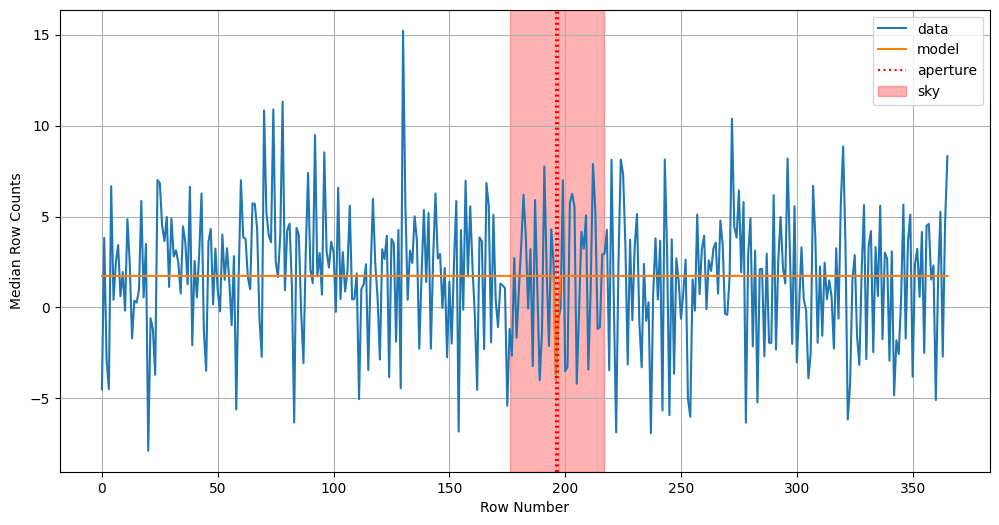

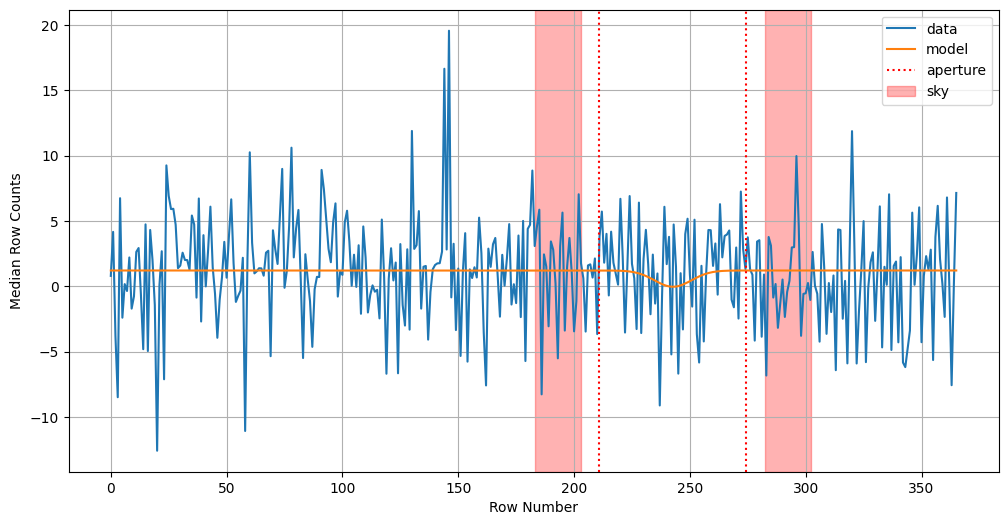

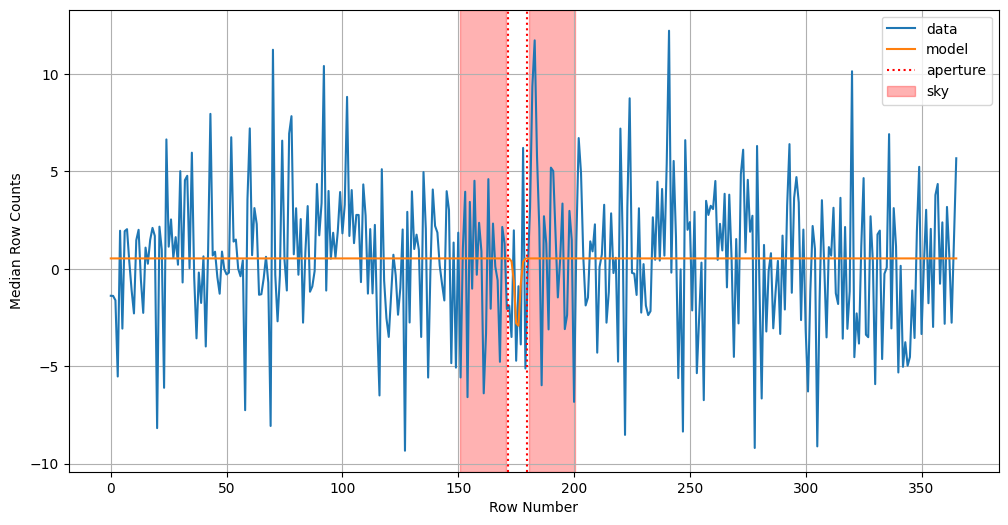

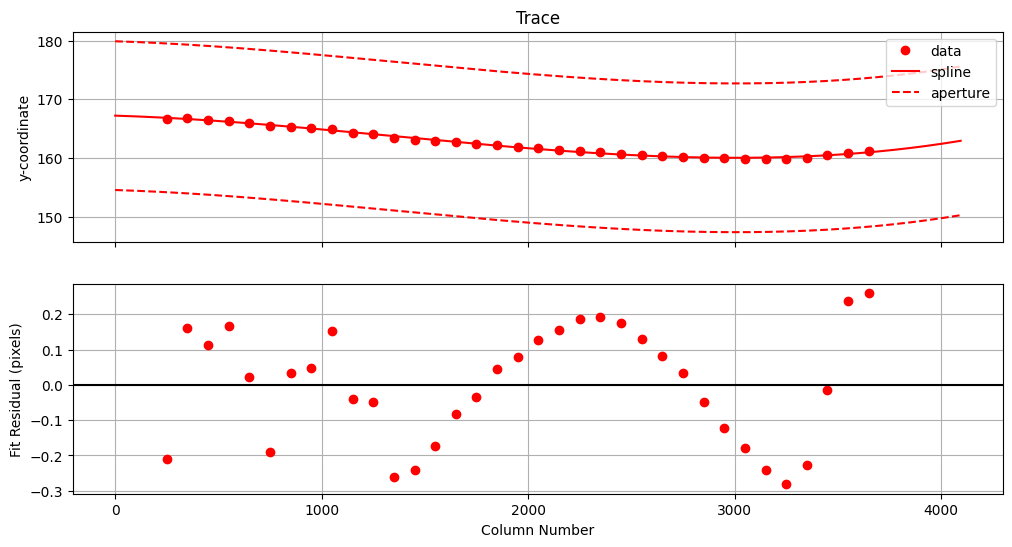

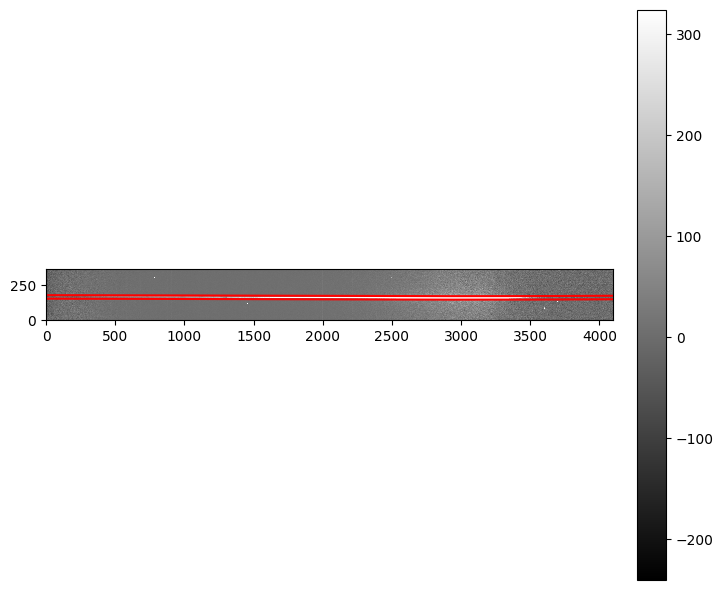

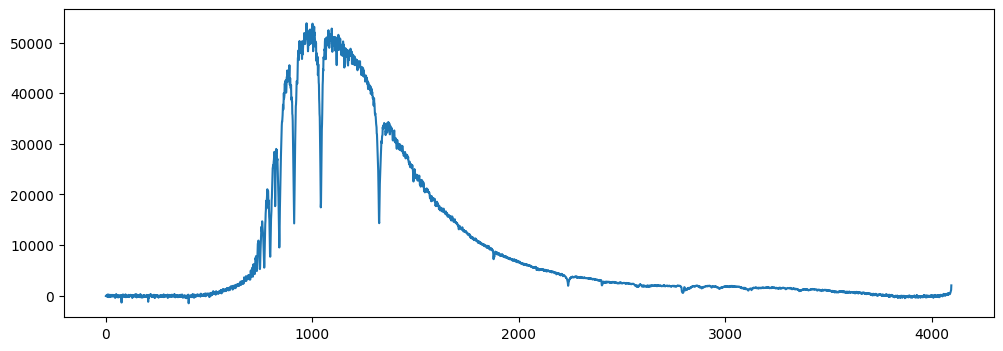

In [27]:
raw_spectrum = calc_trace(red_images[-1].data, center=165, amp=20, t_order=3, plot_diag=True, plot_trace=True)
#raw_spectrum = calc_trace(red_images[-2].data, center=200, amp=20, t_order=3, plot_diag=True, plot_trace=True)
#raw_spectrum = calc_trace(red_images[-3].data, center=200, amp=20, t_order=3, plot_diag=False, plot_trace=True)
#raw_spectrum = raw_spectrum[raw_spectrum>0]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(raw_spectrum)

## Wavelength Solution

Use chauvenet criterion to get the number of sigmas for sigma clipping when fitting the wavelength solution (https://docs.astropy.org/en/stable/modeling/example-fitting-line.html#iterative-fitting-using-sigma-clipping)

Fit a first other function first and then a chevychev or legendre polinomials to fit the residuals.

<AxesSubplot: >

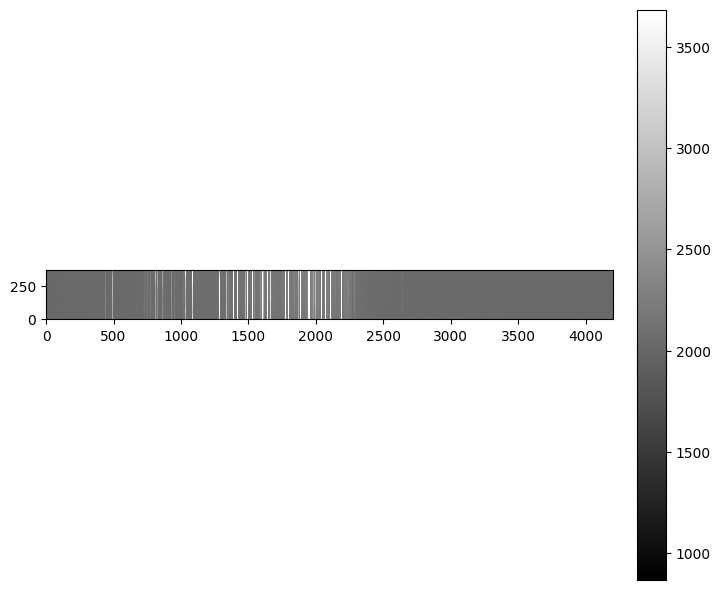

In [28]:
hdu = fits.open('20220916/r1632364.fit')

data = hdu[1].data.T
plot_image(data)

In [29]:
def gaussian(x, *params):
    amp, x0, sigma = params
    return amp * np.exp(-(x - x0)**2 / 2 / sigma**2)

def fit_gauss2peaks(arc_wave, arc_profile, peak_ids):
    
    centers, peaks = [], []
    sigma = 2.5
    for i in peak_ids:
        center = arc_wave[i]
        amplitude = arc_profile[i]
    
        guess = (amplitude, center, sigma)
        bounds = ((0, center-3, 0), (np.inf, center+3, np.inf))

        width = 5
        try:
            popt, pcov = curve_fit(gaussian, 
                                   arc_wave[int(center-width):int(center+width)], 
                                   arc_profile[int(center-width):int(center+width)], 
                                   p0=guess, bounds=bounds)
        except RuntimeError:
            # curve_fit failed to converge...skip
            continue
            
        centers.append(popt[1])
        peaks.append(popt[0])

    centers = np.array(centers)
    peaks = np.array(peaks)
    # filter lamp_lines to keep only lines that were fit
    fit_mask = np.isfinite(centers)
    centers = centers[fit_mask]
    peaks = peaks[fit_mask]
    
    return centers, peaks

In [30]:
def find_arc_peaks(data, optimize=True, plot=False):

    ny, nx = data.shape
    cy, cx = ny//2, nx//2
    
    arc_wave = np.arange(nx)
    arc_profile = data[cy][::-1]  # the axis is inverted
    
    prominence = 100
    peak_ids = find_peaks(arc_profile, prominence=prominence)[0]
    # pick less than X peaks
    max_num_peaks = 30
    step = len(peak_ids)//max_num_peaks + 1
    peak_ids = peak_ids[::step]
    
    raw_wave0 = arc_wave[peak_ids]
    arc_peaks0 = arc_profile[peak_ids]
    
    # saturation mask
    sat_mask = arc_profile < 60000
    arc_wave = arc_wave[sat_mask]
    arc_profile = arc_profile[sat_mask]
    
    if optimize:
        raw_wave, arc_peaks = fit_gauss2peaks(arc_wave, arc_profile, peak_ids)
    else:
        raw_wave = raw_wave0
        arc_peaks = arc_peaks0

    if plot:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(arc_profile)
        ax.scatter(raw_wave0, arc_peaks0, marker='*', color='g', label='peaks')
        if optimize:
            ax.scatter(raw_wave, arc_peaks, marker='*', color='r', label='opt. peaks')
        
        ax.set_ylabel(r'Intensity')
        ax.set_xlabel(r'Pixel Coordinate')
        ax.legend()
        plt.show()
        
    return raw_wave

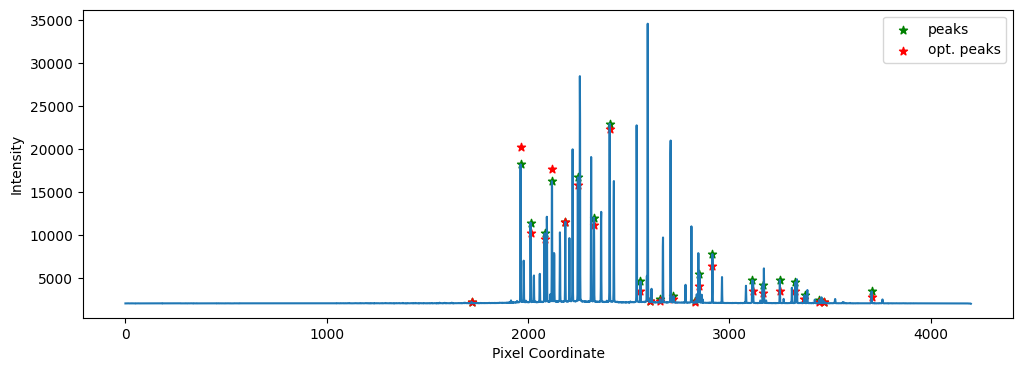

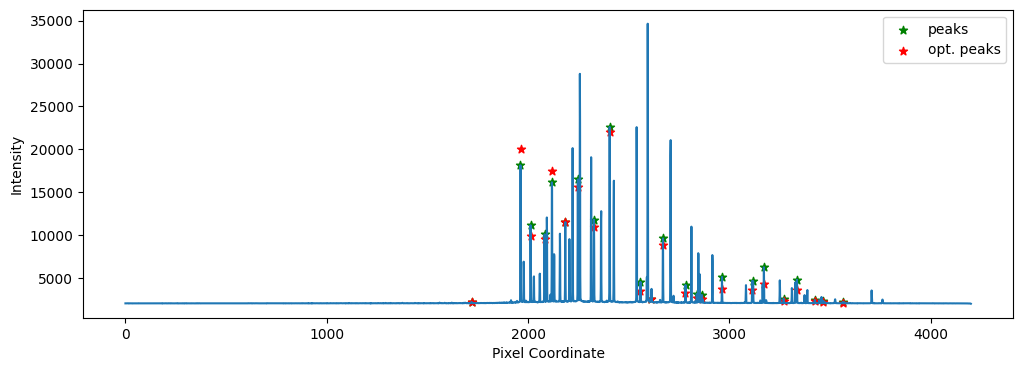

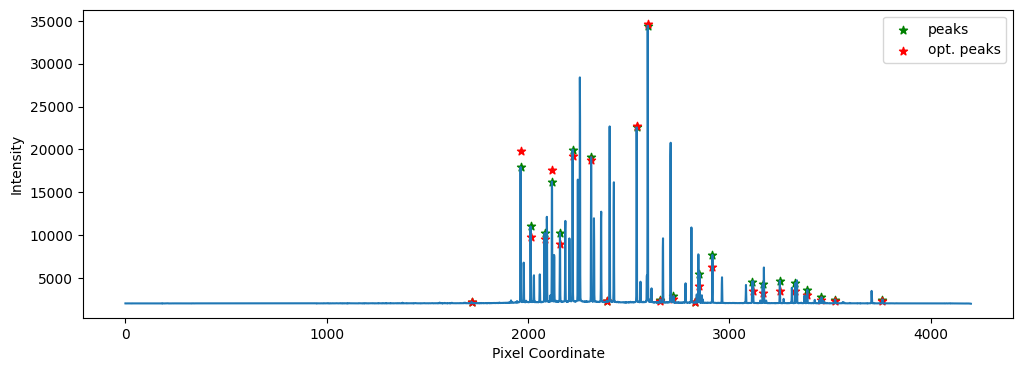

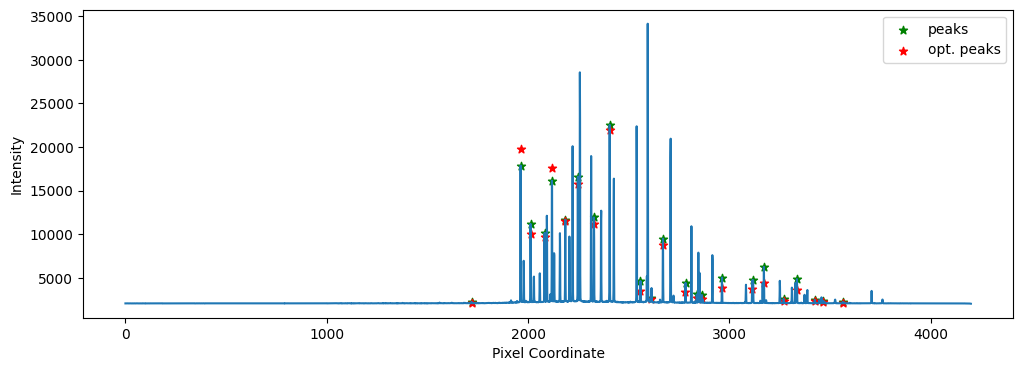

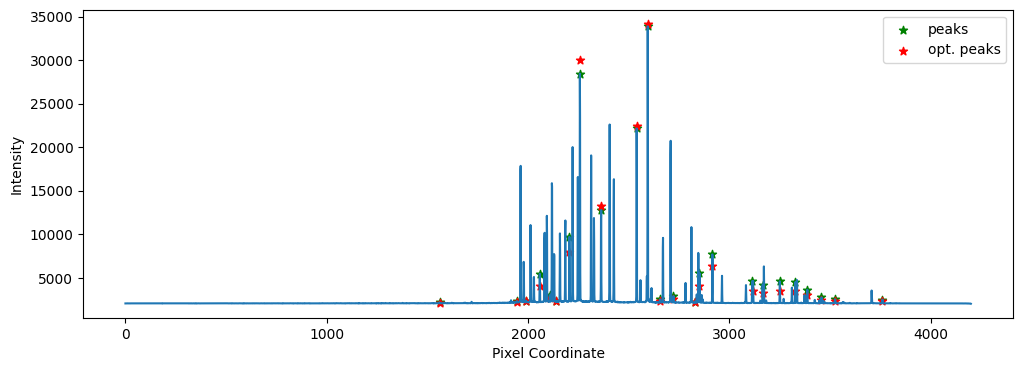

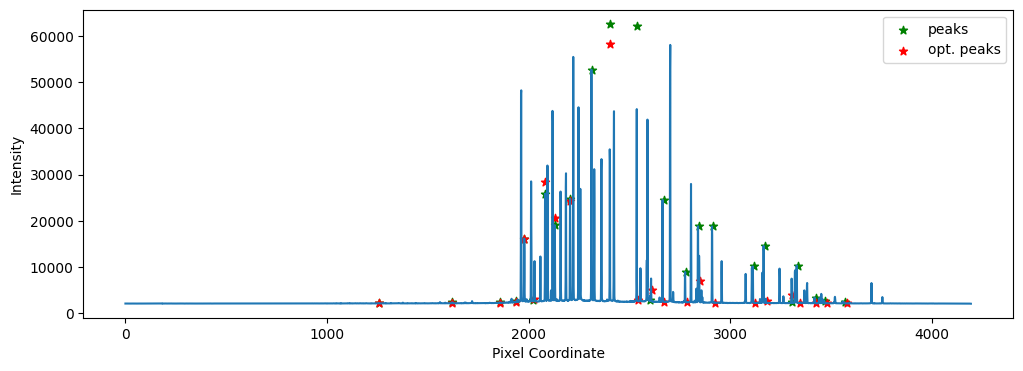

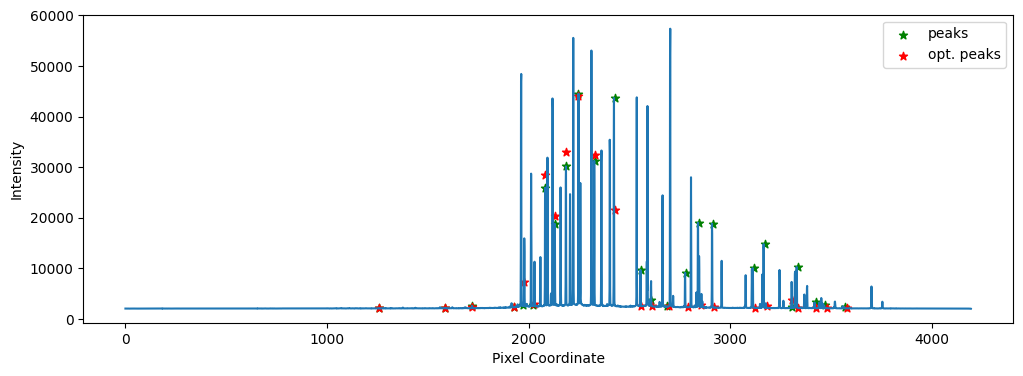

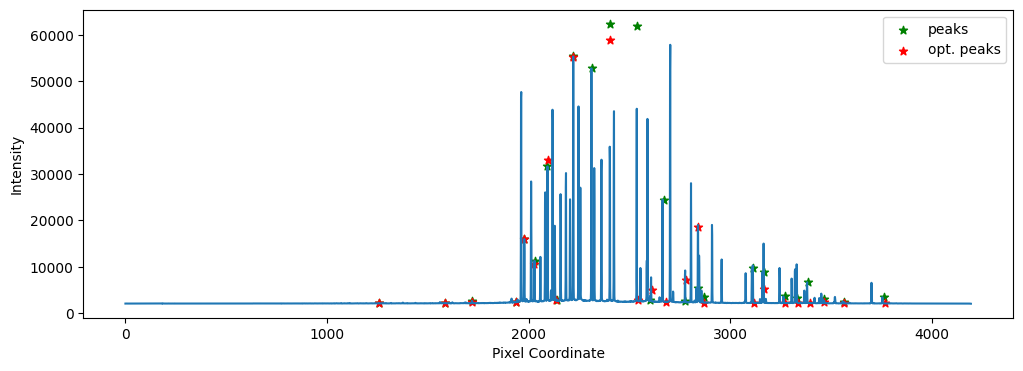

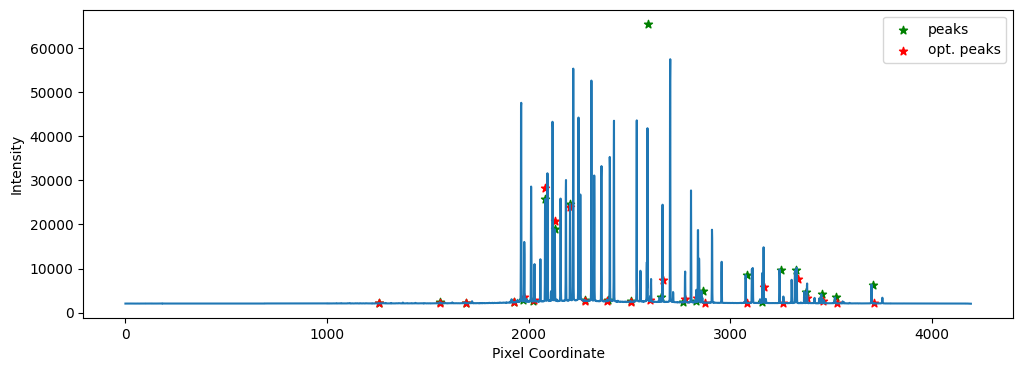

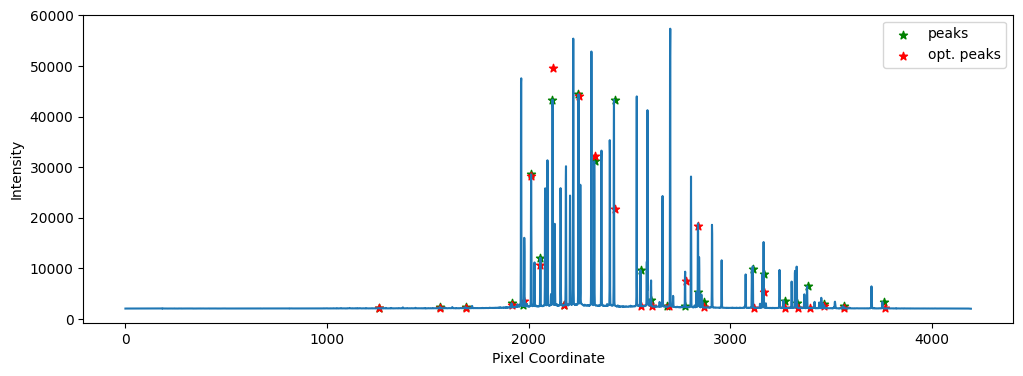

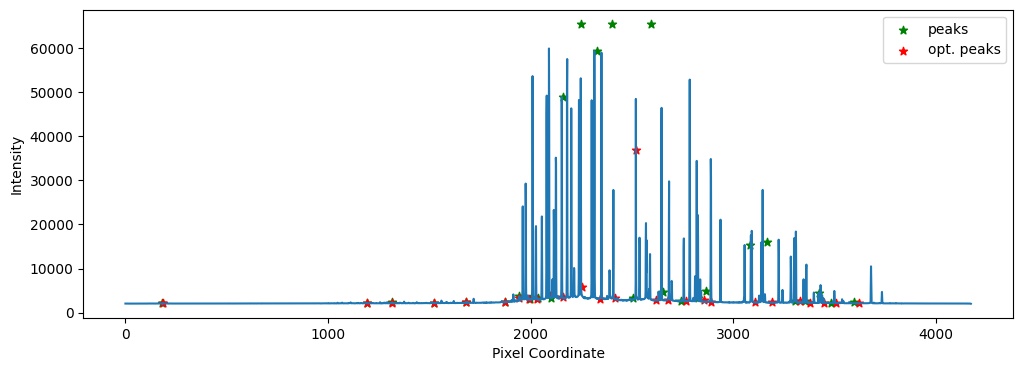

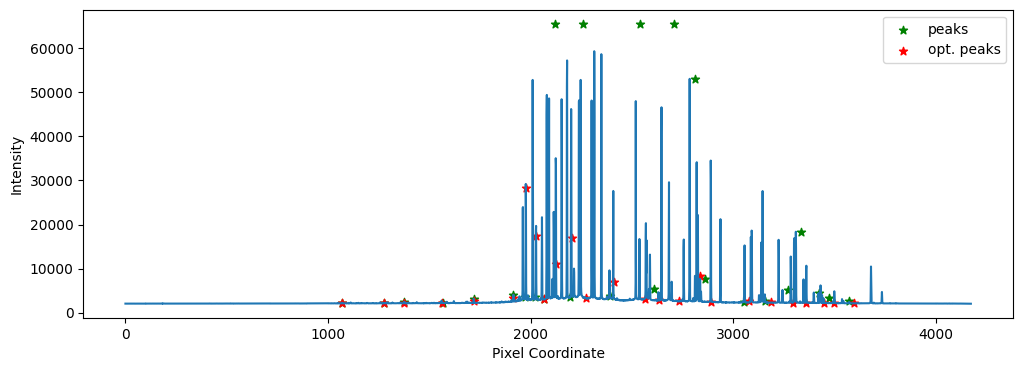

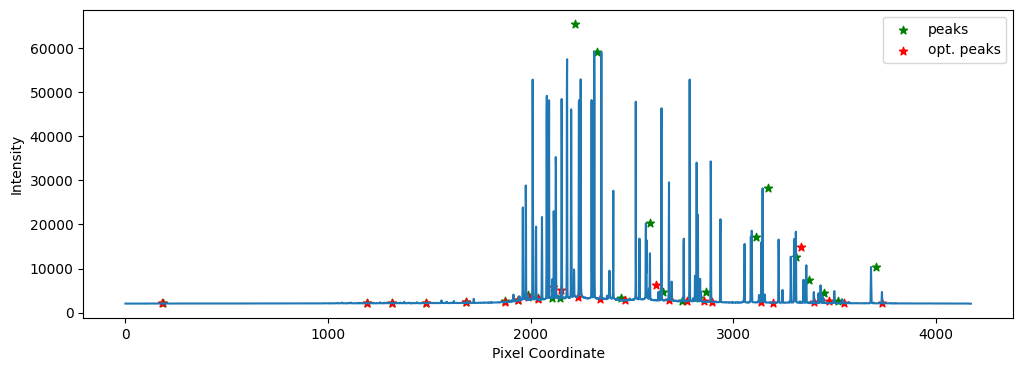

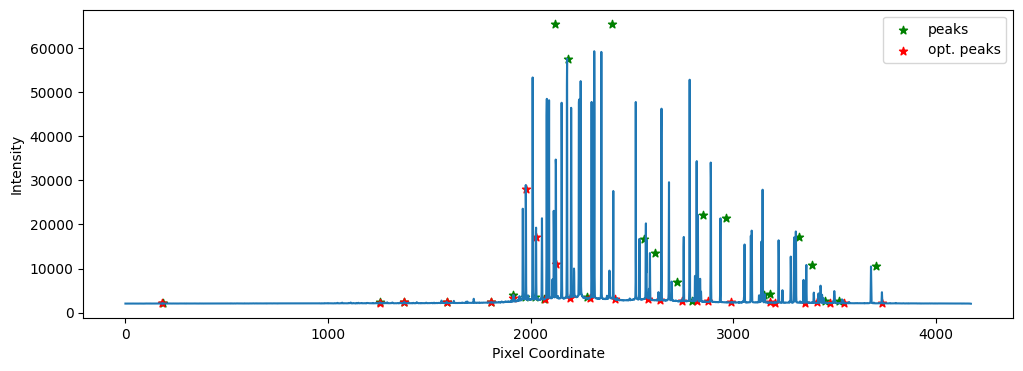

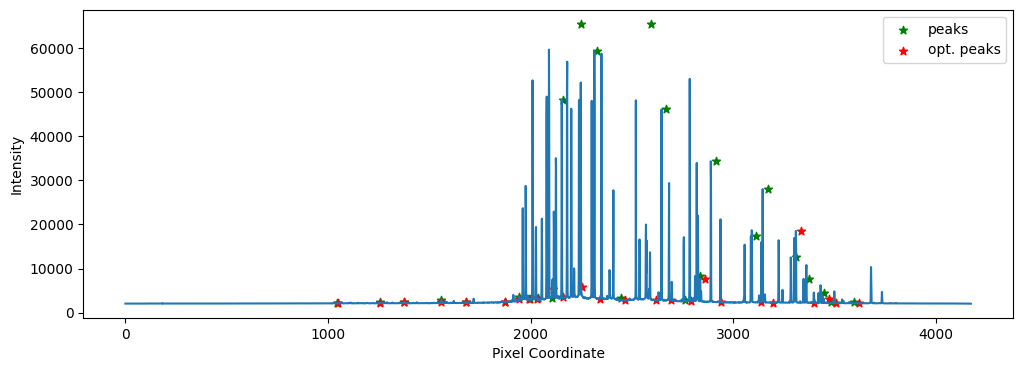

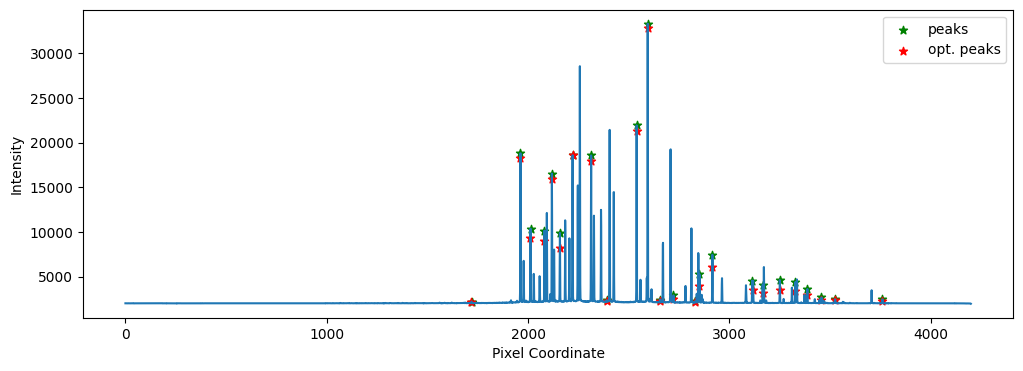

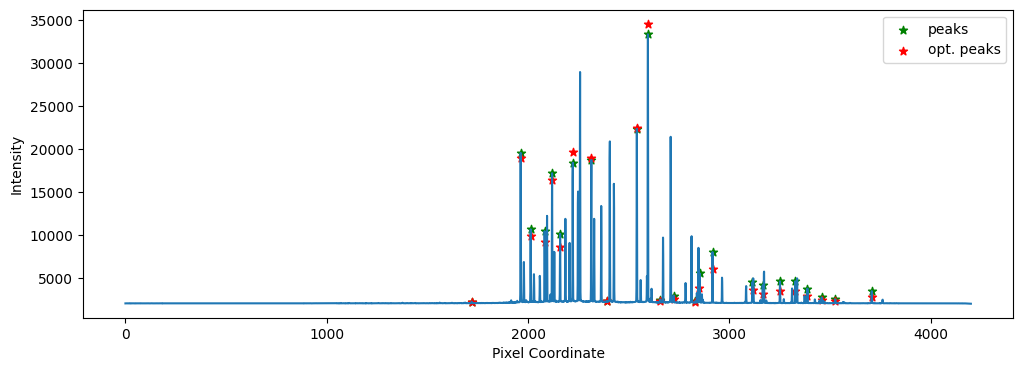

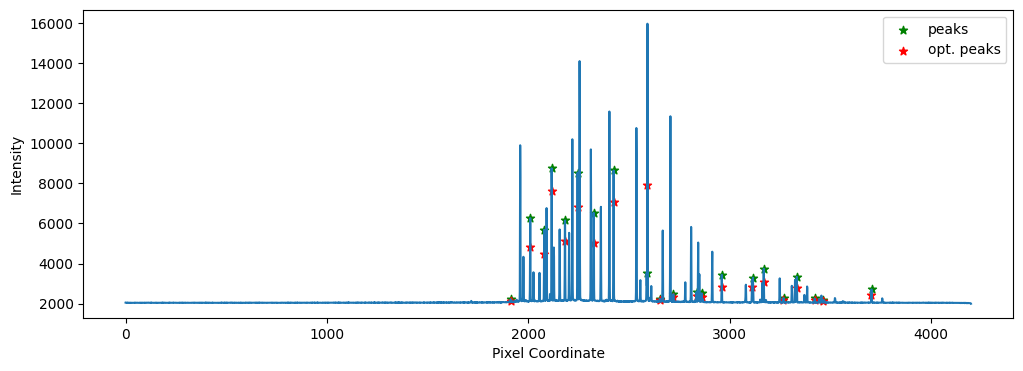

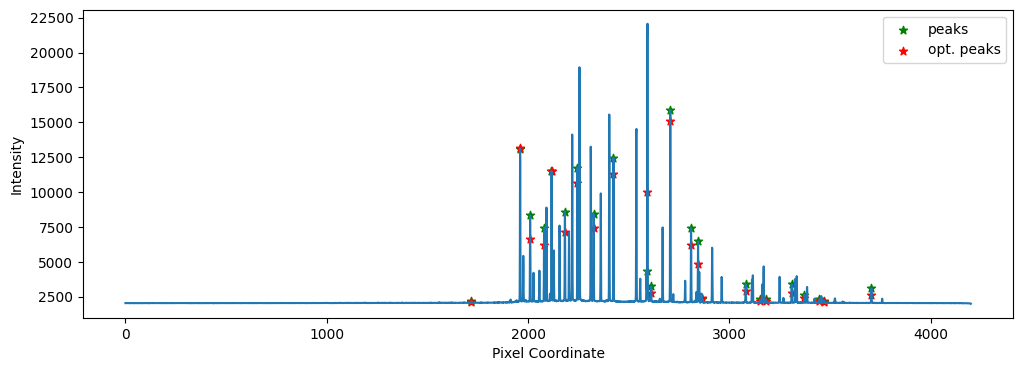

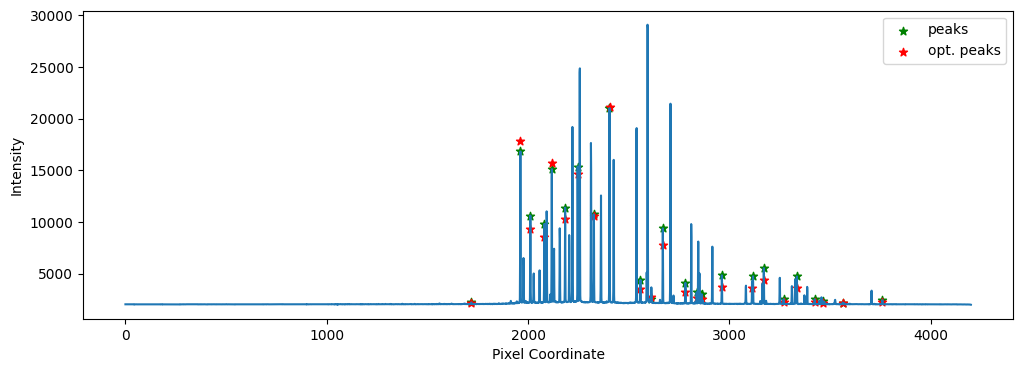

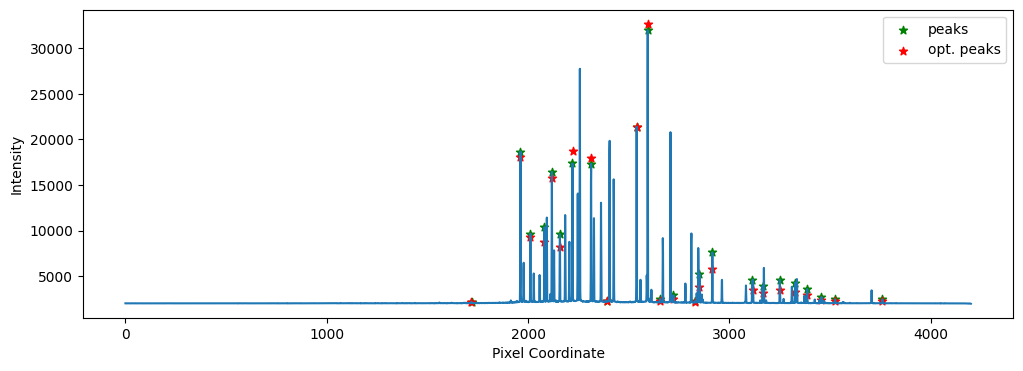

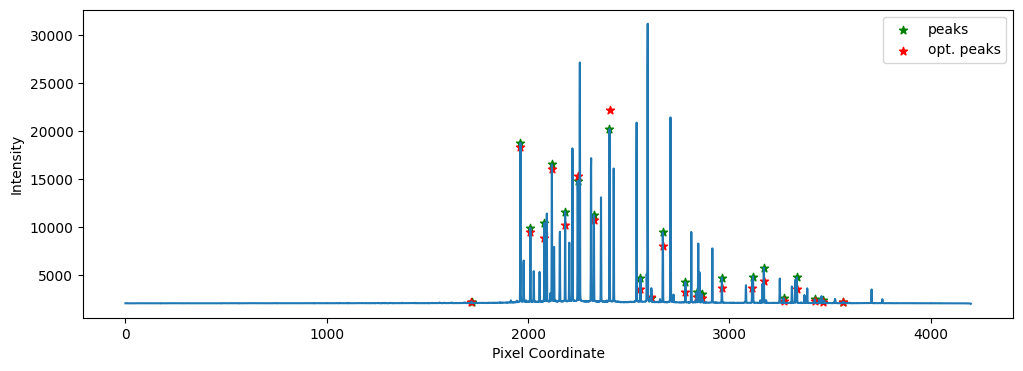

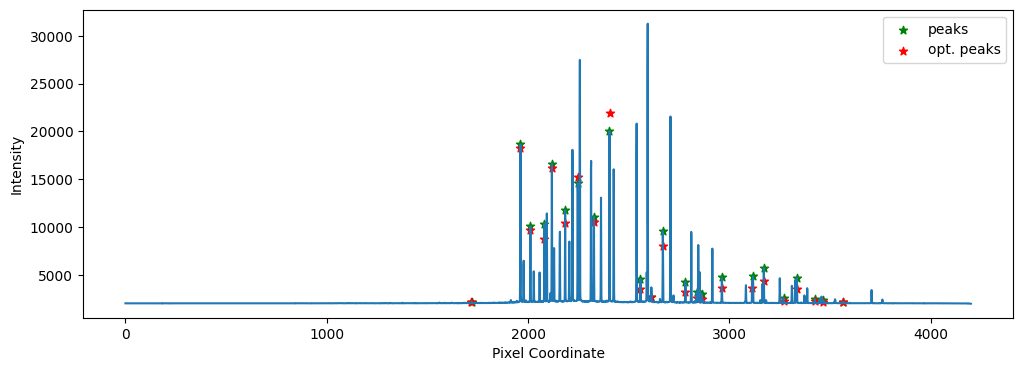

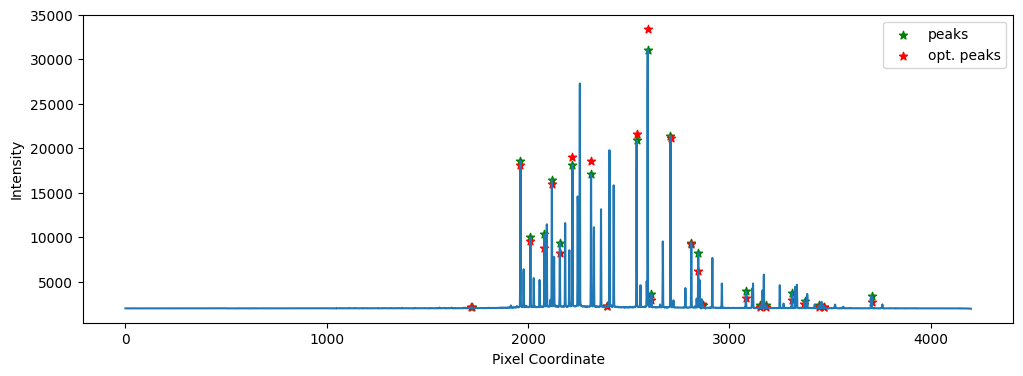

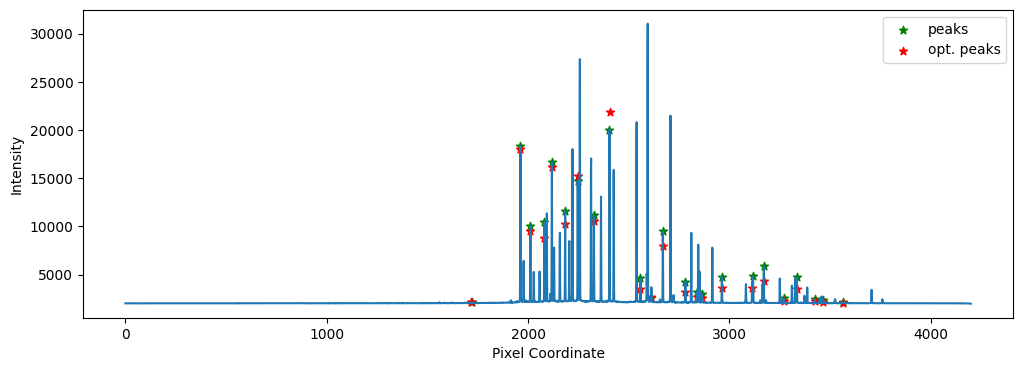

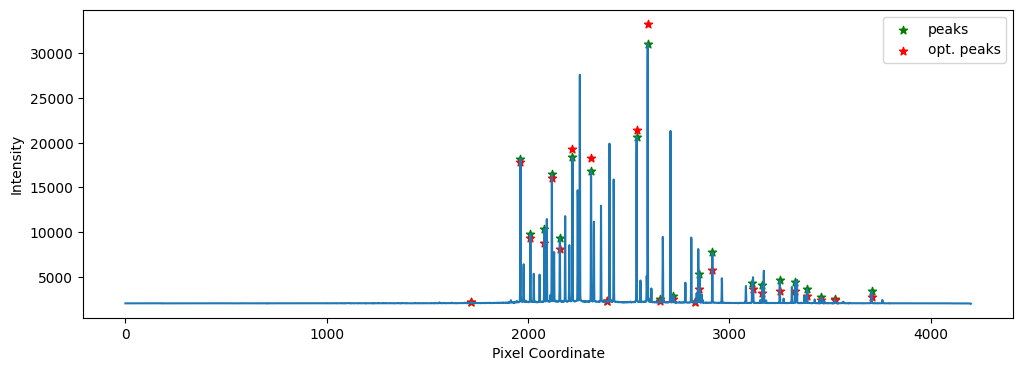

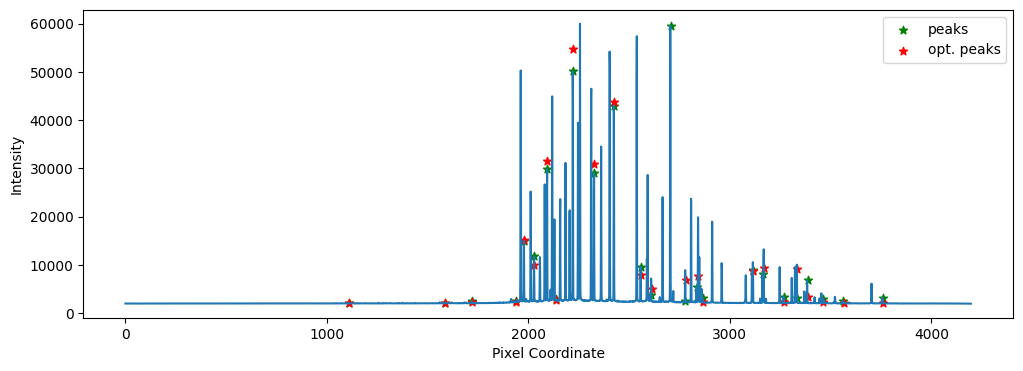

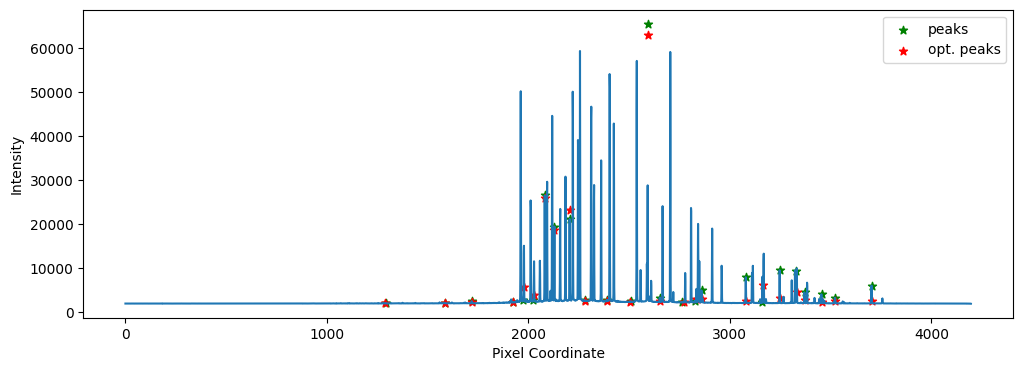

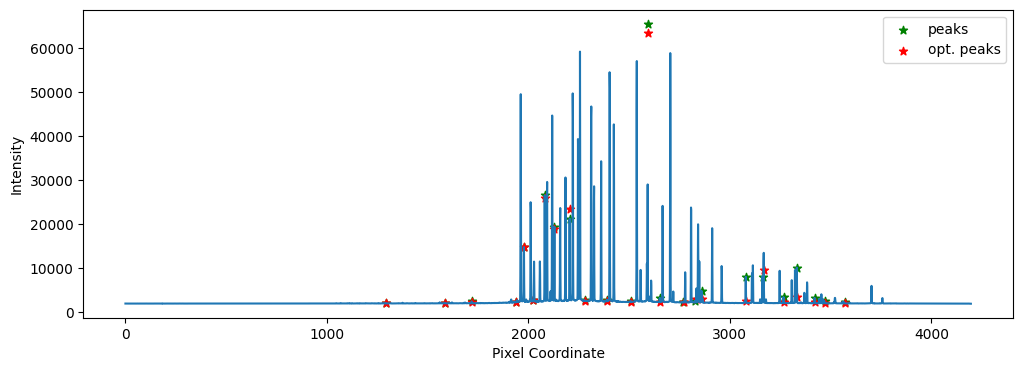

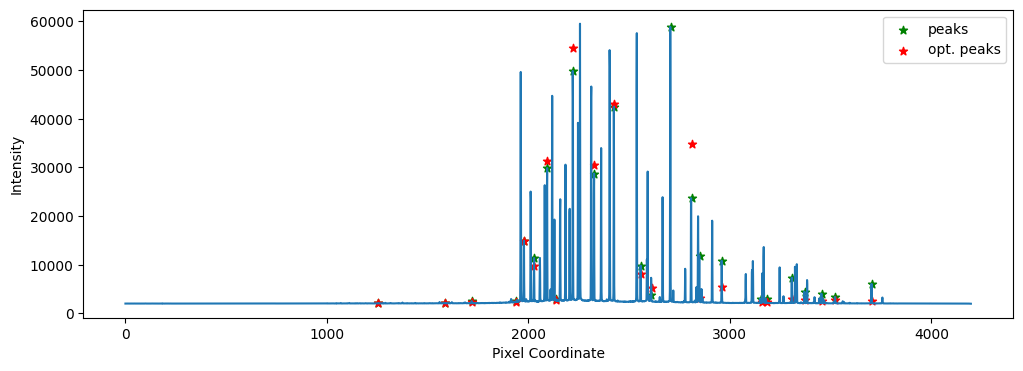

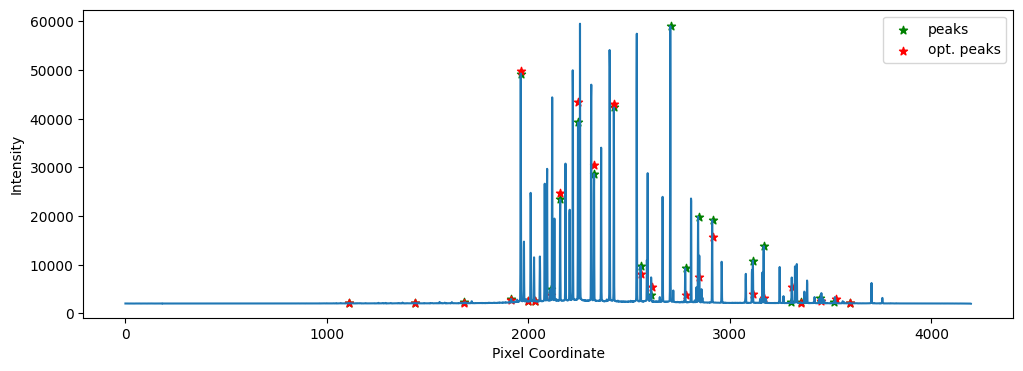

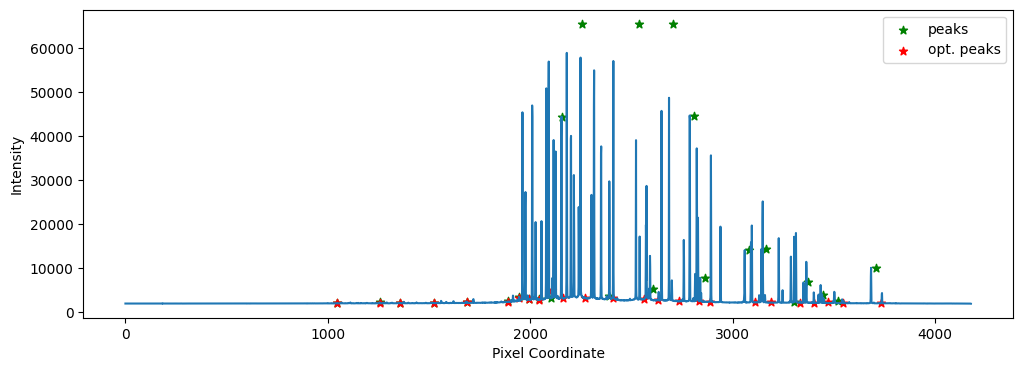

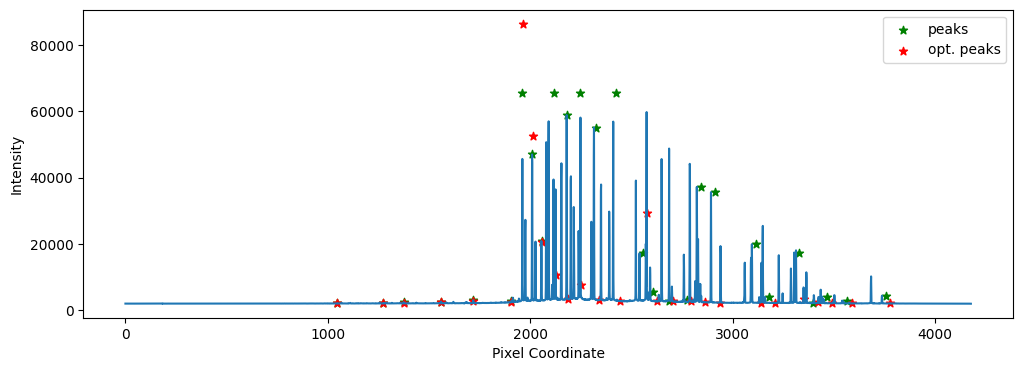

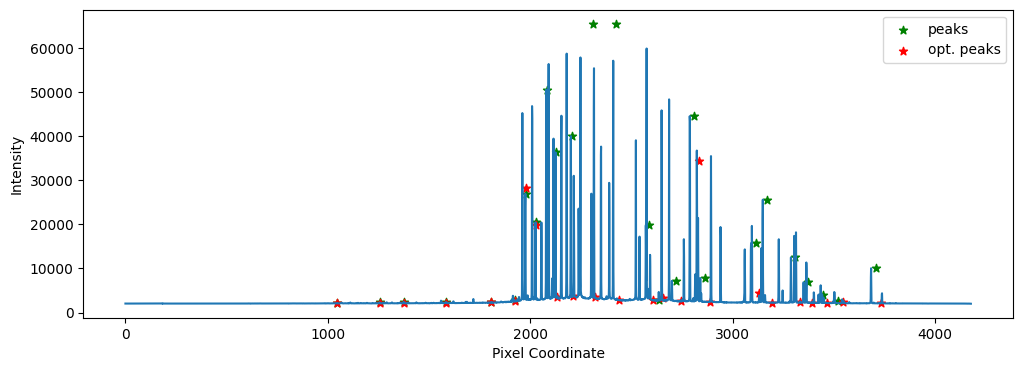

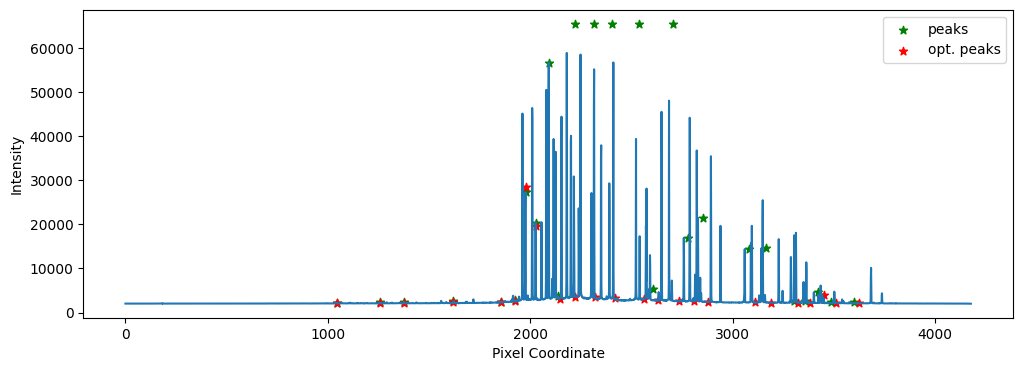

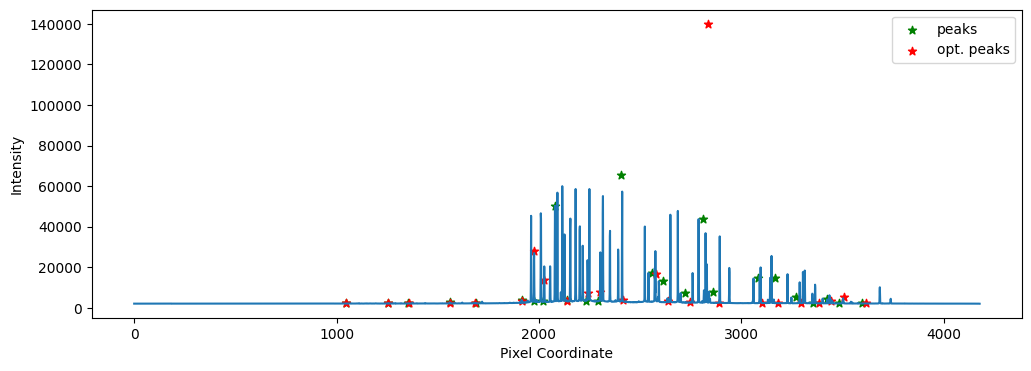

In [31]:
for filename in observations.files_filtered(include_path=True, obstype='ARC'):
    hdu = fits.open(filename)
    data = hdu[1].data.T
    raw_wave = find_arc_peaks(data, plot=True)

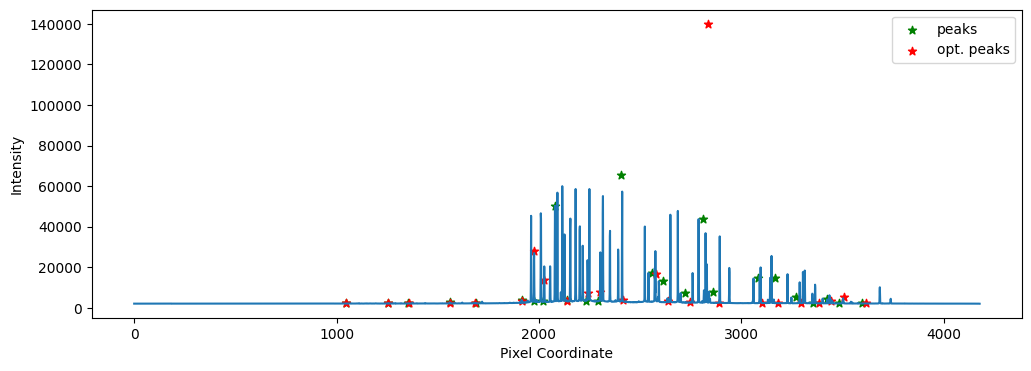

In [32]:
raw_wave = find_arc_peaks(data, plot=True)

In [33]:
def wave_func(params, raw_wave):
    """Linear function for the wavelength solution.
    """
    a, b = params
    model_wave = raw_wave*a + b
    return model_wave

def calc_common_wave(input_wave, model_wave):
    """Find closest wavelengths.
    """
    
    common_wave = []
    for w in model_wave:
        imin = np.argmin(np.abs(w-input_wave))
        diff = np.abs(w-input_wave[imin])
        common_wave.append(input_wave[imin])
        
    return np.array(common_wave)

def chi_sq(params, raw_wave, lamp_wave):
    """Chi squared for the wavelength solution.
    """
    model_wave = wave_func(params, raw_wave)
    common_lamp_wave = calc_common_wave(lamp_wave, model_wave)
    
    chi = np.sum((model_wave-common_lamp_wave)**2 / (len(raw_wave)-len(params)))
    
    return chi

def quick_wave_solution(raw_wave, lamp_wave):

    guess = (1.5, 2000)
    params = fmin(chi_sq, guess, args=(raw_wave, lamp_wave))
    
    return params

In [34]:
def log_likelihood(params, raw_wave, lamp_wave):
    """Logarithm of the likelihood for the wavelength solution.
    """
    model_wave = wave_func(params, raw_wave)
    common_lamp_wave = calc_common_wave(lamp_wave, model_wave)
    
    ll = -0.5 * np.sum((model_wave-common_lamp_wave)**2 / (len(raw_wave)-len(params)))
    
    return ll

def log_prior(params):
    """Flat priors.
    """
    a, b = params
    if 0.0 < a < 3.0 and 0.0 < b < 5000:
        return 0.0
    return -np.inf

def log_probability(params, raw_wave, lamp_wave):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, raw_wave, lamp_wave)

def mcmc_wave_solution(params, raw_wave, lamp_wave):
    
    pos = params + 1e-4 * np.random.randn(32, len(params))
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(raw_wave, lamp_wave)
    )
    sampler.run_mcmc(pos, 5000, progress=True)
    flat_samples = sampler.get_chain(discard=1000, thin=30, flat=True)
    
    mcmc_params = []
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        mcmc_params.append(mcmc[1])

    return mcmc_params

In [35]:
def wave_solution(raw_wave, lamp_wave, quick=False):

    params = quick_wave_solution(raw_wave, lamp_wave)
    
    if not quick:
        params = mcmc_wave_solution(params, raw_wave, lamp_wave)
            
    return params

In [36]:
def check_solution(params, raw_wave, lamp_wave):
    calib_wave = wave_func(params, raw_wave)
    common_lamp_wave = calc_common_wave(lamp_wave, calib_wave)
    res = calib_wave - common_lamp_wave

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(raw_wave, res, marker='*', c='r')
    
    mean, std = np.mean(res), np.std(res)
    ax.axhline(mean, c='k')
    ax.axhline(mean+std, c='k', ls='--')
    ax.axhline(mean-std, c='k', ls='--')
    
    ax.set_ylabel(r'Wavelength Residual ($\AA$)')
    ax.set_xlabel(r'Pixel Coordinate')
    ax.set_ylim(mean-3*std, mean+3*std)

    print(f'Residual mean: {mean:.1f} +/- {std:.1f}')

Optimization terminated successfully.
         Current function value: 6.615489
         Iterations: 41
         Function evaluations: 90


100%|██████████████████████████████████████| 5000/5000 [00:13<00:00, 374.87it/s]


Residual mean: -0.1 +/- 4.9


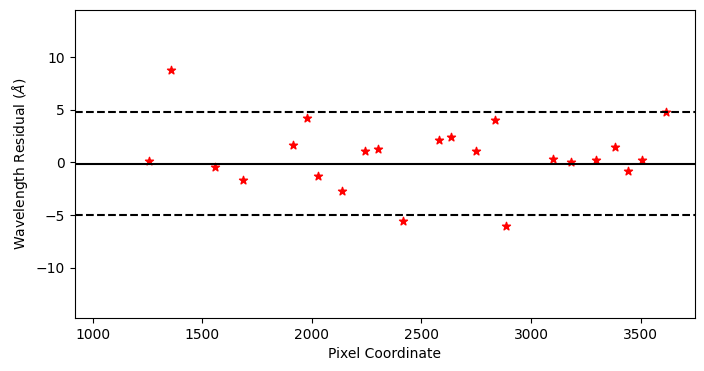

In [37]:
lamp_wave = np.loadtxt('lamp/CuArNe_high.dat').T
#lamp_wave = np.loadtxt('lamp/CuNe_high.dat').T
raw_wave = find_arc_peaks(data)
params = wave_solution(raw_wave, lamp_wave, quick=False)

check_solution(params, raw_wave, lamp_wave)

### Wavelength-calibrated Spectrum

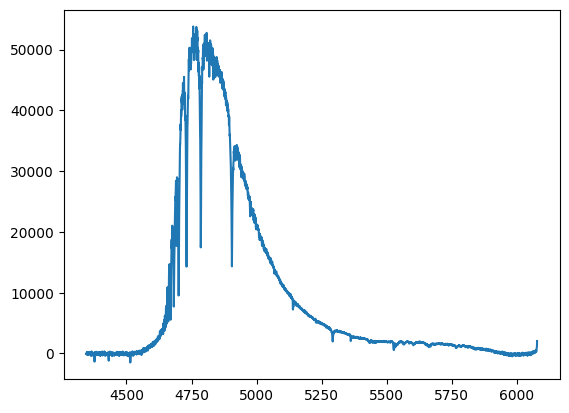

In [38]:
raw_wave = np.arange(raw_spectrum.shape[0])
cal_wave = wave_func(params, raw_wave)

plt.plot(cal_wave, raw_spectrum)
#plt.ylim(None, 1000)

In [200]:
#np.savetxt('int_AT2021aess.txt', np.array([cal_wave, raw_spectrum]).T)
#np.savetxt('int_SN2022esa.txt', np.array([cal_wave, raw_spectrum]).T)

## Flux Calibration

https://www.eso.org/sci/observing/tools/standards/spectra/stanlis.html

https://www.ing.iac.es//Astronomy/tonotes/misc/systemcat.html#specstd 

In [2]:
# standard star 114-750, a.k.a. HR8634
filename = 'https://ftp.eso.org/pub/usg/standards/ctiostan/fhr8634.dat'

dtype = []
dtype.append( ('wave', float) )
dtype.append( ('flux', float) )  # units are ergs/cm/cm/s/A * 10**16
dtype.append( ('eflux', float) )
dtype.append( ('dlam', float) )
calspec = np.genfromtxt(filename, dtype=dtype)

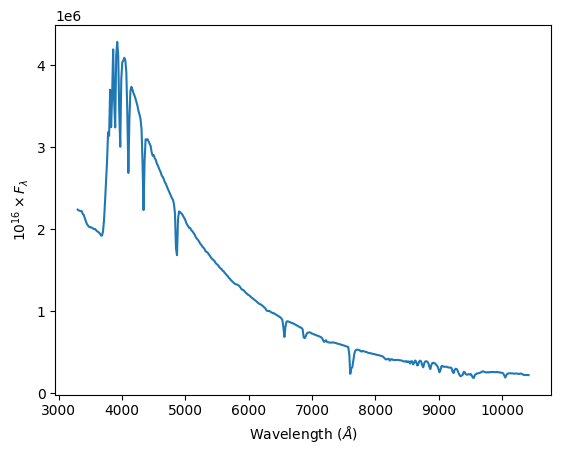

In [3]:
# plot the tabulated flux densities
plt.plot(calspec['wave'], calspec['flux']);
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel(r'$10^{16} \times F_{\lambda}$');
#plt.yscale('log');

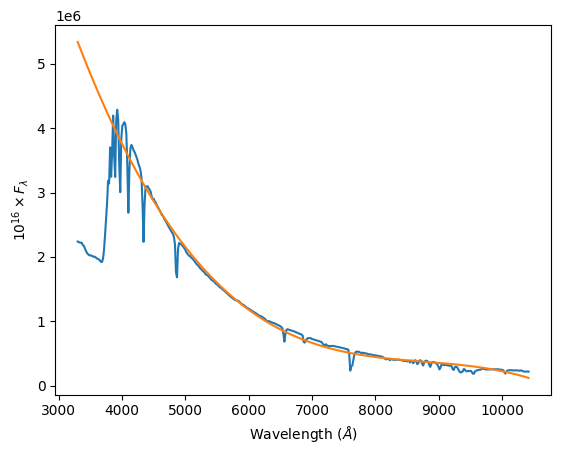

In [17]:
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting.continuum import fit_continuum

spectrum = Spectrum1D(flux=calspec['flux']*u.erg, spectral_axis=calspec['wave']*u.angstrom)

region = [(4000*u.angstrom, 8000*u.angstrom), (8000*u.angstrom, 11000*u.angstrom)]

with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    g1_fit = fit_continuum(spectrum, window=region)
    
continuum_fit = g1_fit(calspec['wave']*u.angstrom)

# plot the tabulated flux densities
plt.plot(calspec['wave'], calspec['flux']);
plt.plot(calspec['wave'], continuum_fit);
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel(r'$10^{16} \times F_{\lambda}$');
#plt.yscale('log');

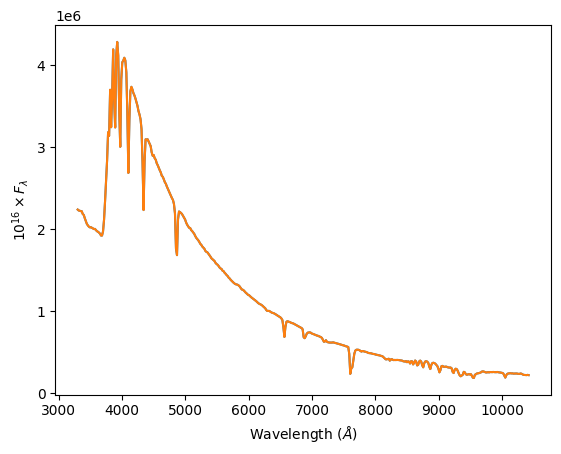

In [28]:
t = np.arange(calspec['wave'][1], calspec['wave'][-2], int(np.median(calspec['dlam'])))
stdflux = LSQUnivariateSpline(calspec['wave'], calspec['flux'], t, calspec['eflux'], k=2)

# plot the tabulated flux densities
plt.plot(calspec['wave'], calspec['flux']);
plt.plot(calspec['wave'], stdflux(calspec['wave']));
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel(r'$10^{16} \times F_{\lambda}$');
#plt.yscale('log');

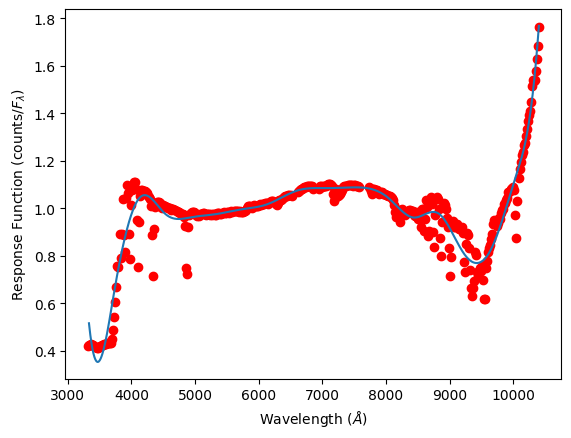

In [24]:
#ratios = raw_spectrum / stdflux(cal_wave)
ratios = calspec['flux'] / continuum_fit
w = (calspec['wave'] > calspec['wave'].min()) \
    & (calspec['wave'] < calspec['wave'].max()) \
    & (np.abs(calspec['wave'] - 7650) > 70) \
    & (np.abs(calspec['wave'] - 6900) > 40) \
    & (np.abs(calspec['wave'] - 6563) > 40) \

# fit a spline to the ratios to determine the response function
t = calspec['wave'][w][1:-2:25]
respfn = LSQUnivariateSpline(calspec['wave'][w], ratios[w], t)

plt.plot(calspec['wave'][w], ratios[w], 'ro')
xwav = np.linspace(calspec['wave'][w][1], calspec['wave'][w][-1], 1000)
plt.plot(xwav, respfn(xwav));
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Response Function (counts/$F_{\lambda}$)');

In [25]:
# compare the tabulated and extracted flux densities (applying the response function)
plt.plot(cal_wave, raw_spectrum / respfn(cal_wave), label='Extracted Spectrum')
plt.plot(calspec['wave'], calspec['flux'], label='Tabulated (published) Spectrum')
plt.xlim(3500, 7200) # standard star values are only tabulated out to ~9200 A
plt.ylim(0, 1e7)

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$F_{\lambda}$')
#plt.ylim(50, 1000)
#plt.yscale('log')
plt.legend();

NameError: name 'cal_wave' is not defined

(-1000000.0, 10000000.0)

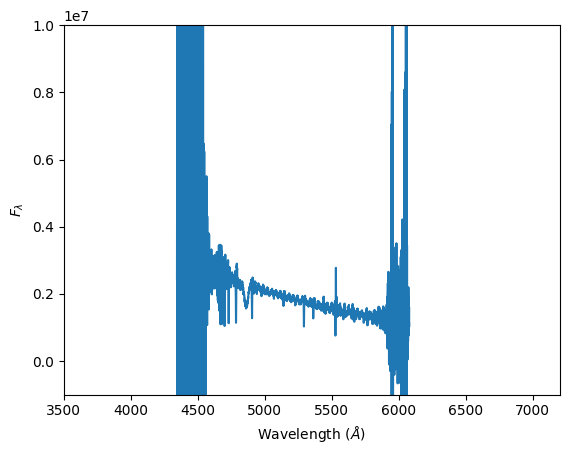

In [44]:
raw_wave = np.arange(raw_spectrum.shape[0])
cal_wave = wave_func(params, raw_wave)

plt.plot(cal_wave, raw_spectrum / respfn(cal_wave))
plt.xlim(3500, 7200)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$F_{\lambda}$')
plt.ylim(-1e6, 1e7)